In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
from collections import defaultdict
import os
from evaluate_flipflop import get_digit_accuracy, get_relaxed_distance_accuracy, get_strict_distance_accuracy, get_per_dist_accuracy

In [36]:
def get_data(path):
    with open(path, 'r') as file:
        data = [json.loads(line) for line in file]
    return data

def get_base_accuracy(responses):
    """
    Calculates the baseline (raw) accuracy of the reported answers
    :param responses: list of dictionaries containing model's answers
    :return: float, correct answers proportion
    """

    correct = 0
    for response in responses:
        try:
            if int(response['answer']) == int(response['last_valid_token']):
                correct += 1
        except Exception as e:
            #print(f'Invalid response given {response['answer']}')
            continue

    return correct / len(responses)

In [6]:
def get_of_length(length, path):
    data = get_data(path)

    flipflop_of_length = []
    for line in data:
        if len(line['flipflop']) == length:
            flipflop_of_length.append(line)

    return flipflop_of_length

In [7]:
# could have just taken lengths and positions from the file name but oh well
def count_custom_length(input_string):
    # Define keywords and their lengths
    keywords = ["write", "read", "ignore"]
    keyword_length = 1

    i = 0
    total_length = 0

    while i < len(input_string):
        # Check if the substring matches any of the keywords
        matched = False
        for keyword in keywords:
            if input_string[i:i+len(keyword)] == keyword:
                total_length += keyword_length
                i += len(keyword)
                matched = True
                break

        # If no keyword matches, check if it's a digit
        if not matched:
            if input_string[i].isdigit():
                total_length += 1
                i += 1
            else:
                raise ValidationError

    return total_length

In [8]:
def find_last_write_idx(input_string):
    pattern = r'(write|read|ignore)([01])'
    
    matches = re.findall(pattern, input_string)
    
    result = []
    for action, number in matches:
        result.append(action)
        result.append(number)

    for i in range(len(result)-1, -1, -1):
        if result[i] == "write":
            return i

In [40]:
def plot_distance_accuracy(models, title, output_path, fig_width=26, fig_height=7, bar_width=0.2):
    """
    Creates a grouped histogram plot of average base accuracy by flipflop length across models.

    Args:
        models (dict): Dictionary where keys are model names and values are lists of folder paths.
        output_path (str): Path to save the generated plot.

    Returns:
        None
    """
    model_results = {}
    
    for model_name, folders in models.items():
        all_samples = []

        for folder_path in folders:
            for file_name in os.listdir(folder_path):
                if file_name.endswith(".jsonl"):
                    file_path = os.path.join(folder_path, file_name)
                    try:
                        with open(file_path, 'r', encoding='utf-8') as file:
                            one_sample_data = [json.loads(line) for line in file if line.strip()]
                            
                            if not one_sample_data:  # Check for empty data
                                print(f"Warning: {file_path} is empty or has no valid data")
        
                            all_samples.append(one_sample_data)
        
                    except json.JSONDecodeError:
                        print(f"Error: Failed to decode JSON in {file_path}")
    
        print(f"{model_name}: Loaded {len(all_samples)} entries from all folders.")
    
        grouped_accuracies = defaultdict(list)
    
        for result in all_samples:
            acc = get_base_accuracy(result)
            length = len(result[0]['flipflop'])
            idx = result[0]['last_write_index']
            grouped_accuracies[(length, idx)].append(acc)
    
        grouped_results = {}
        for (length, idx), accuracies in grouped_accuracies.items():
            avg_acc = sum(accuracies) / len(accuracies)
            grouped_results[(length, idx)] = avg_acc
    
        length_indices = defaultdict(set)
        for (length, idx) in grouped_results.keys():
            length_indices[length].add(idx)
    
        filtered_results = {}
        for length, indices in length_indices.items():
            if len(indices) >= 2:  
                first_idx = min(indices)
                last_idx = max(indices)
                filtered_results[(length, first_idx)] = grouped_results[(length, first_idx)]
                filtered_results[(length, last_idx)] = grouped_results[(length, last_idx)]
    
        model_results[model_name] = dict(sorted(filtered_results.items(), key=lambda x: (x[0][0], x[0][1])))
    
    plt.figure(figsize=(fig_width, fig_height))
    
    x_labels = []
    all_model_accuracies = []
    all_model_names = []
    all_groups = sorted({k for model in model_results.values() for k in model.keys()})
    
    for model_name, results in model_results.items():
        model_accuracies = [results.get(group, None) for group in all_groups]
        all_model_accuracies.append(model_accuracies)
        all_model_names.append(model_name)
    
    x_labels = [f"Len: {k[0]}, Idx: {k[1]}" for k in all_groups]
    x_positions = np.arange(len(x_labels))
    
    for i, (model_name, model_accuracies) in enumerate(zip(all_model_names, all_model_accuracies)):
        plt.bar(x_positions + i * bar_width, model_accuracies, width=bar_width, label=model_name)
    
    plt.axhline(y=0.5, color='red', linestyle='--', label="Baseline")  # Optional reference line
    
    plt.xlabel("Group (Flipflop Length, Last Write Index)")
    plt.ylabel("Average Base Accuracy")
    plt.title(title)
    plt.xticks(x_positions + (bar_width * (len(all_model_names) - 1) / 2), x_labels, rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()


In [38]:
def plot_model_accuracy(models, title, output_path, fig_width=26, fig_height=7, bar_width=0.15):
    """
    Creates a grouped histogram plot of average base accuracy by flipflop length across models.

    Args:
        models (dict): Dictionary where keys are model names and values are lists of folder paths.
        output_path (str): Path to save the generated plot.

    Returns:
        None
    """
    # Aggregate results for all models
    results_by_model = {}
    for model_name, folders in models.items():
        all_samples = []
        for folder_path in folders:
            for file_name in os.listdir(folder_path):
                if file_name.endswith(".jsonl"):
                    file_path = os.path.join(folder_path, file_name)
                    with open(file_path, 'r', encoding='utf-8') as file:
                        one_sample_data = [json.loads(line) for line in file]
                        all_samples.append(one_sample_data)

        # Aggregate accuracies by sparse length
        acc_by_length = defaultdict(list)
        for result in all_samples:
            acc = get_base_accuracy(result)
            if 'worded' in model_name:
                length = count_custom_length(result[0]['flipflop'])
            else:
                length = len(result[0]['flipflop'])
            acc_by_length[length].append(acc)

        # Calculate average accuracy for each sparse length
        average_acc_by_length = {length: sum(accs) / len(accs) for length, accs in acc_by_length.items()}
        results_by_model[model_name] = average_acc_by_length

    # Extract lengths in steps of 50 and prepare data for plotting
    all_lengths = sorted(set(k for model_results in results_by_model.values() for k in model_results.keys()))
    selected_lengths = [length for length in all_lengths if length % 50 == 0]

    # Prepare data for grouped histogram
    plot_data = {model: [results_by_model[model].get(length, 0) for length in selected_lengths] for model in models.keys()}

    # Plot grouped histogram
    x = np.arange(len(selected_lengths))  # the label locations
    width = bar_width  # the width of the bars

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    for i, (model, accuracies) in enumerate(plot_data.items()):
        ax.bar(x + i * width, accuracies, width, label=model)

    baseline = 0.5
    ax.axhline(y=baseline, color='red', linestyle='--', linewidth=1.5, label='50% Baseline')

    # Add labels, title, and legend
    ax.set_xlabel('Flipflop Length')
    ax.set_ylabel('Average Base Accuracy')
    ax.set_title(title)
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(selected_lengths)
    ax.legend(fontsize=14)

    # Show grid
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Save and display the plot
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()


# SPARSE

# All models on subtasks (regular, worded, qa, qa-worded)

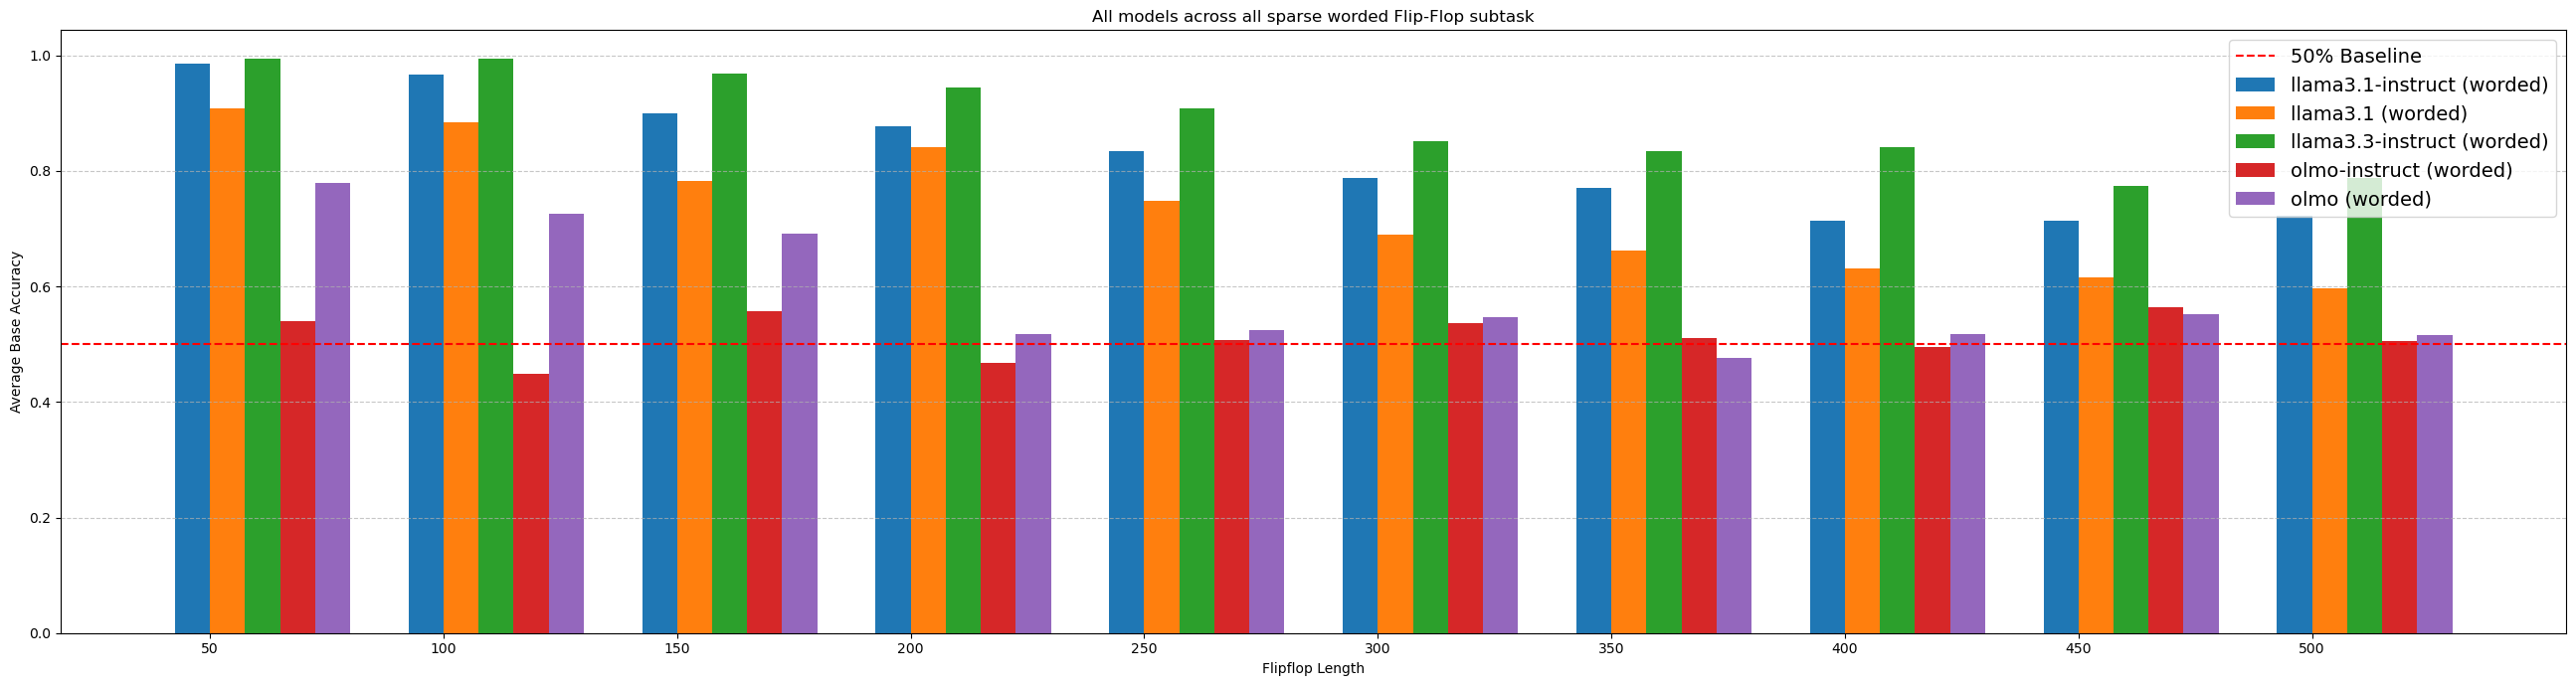

In [7]:
# SPARSE WORDED
models = {
    "llama3.1-instruct (worded)": ["llama3.1_70B-instruct/sparse-worded/s1", 
                          "llama3.1_70B-instruct/sparse-worded/s2", 
                          "llama3.1_70B-instruct/sparse-worded/s3", 
                          "llama3.1_70B-instruct/sparse-worded/s4", 
                          "llama3.1_70B-instruct/sparse-worded/s5"],
    "llama3.1 (worded)": ["llama3.1_70B/sparse-worded/s1", 
                 "llama3.1_70B/sparse-worded/s2", 
                 "llama3.1_70B/sparse-worded/s3", 
                 "llama3.1_70B/sparse-worded/s4", 
                 "llama3.1_70B/sparse-worded/s5"],
        "llama3.3-instruct (worded)": ["llama3.3_70B-instruct/sparse-worded/s1", 
                 "llama3.3_70B-instruct/sparse-worded/s2", 
                 "llama3.3_70B-instruct/sparse-worded/s3", 
                 "llama3.3_70B-instruct/sparse-worded/s4", 
                 "llama3.3_70B-instruct/sparse-worded/s5"],
    "olmo-instruct (worded)": ["OLMo_7B-instruct/sparse-worded/s1", 
                         "OLMo_7B-instruct/sparse-worded/s2",
                         "OLMo_7B-instruct/sparse-worded/s3",
                         "OLMo_7B-instruct/sparse-worded/s4",
                         "OLMo_7B-instruct/sparse-worded/s5"],
    "olmo (worded)": ["OLMo_7B/sparse-worded/s1", 
            "OLMo_7B/sparse-worded/s2",
            "OLMo_7B/sparse-worded/s3",
            "OLMo_7B/sparse-worded/s4",
            "OLMo_7B/sparse-worded/s5"],
}
title = "All models across all sparse worded Flip-Flop subtask"
output_path = 'graphs/models_across_sparse_worded_flipflop.png'

plot_model_accuracy(models, title, output_path)


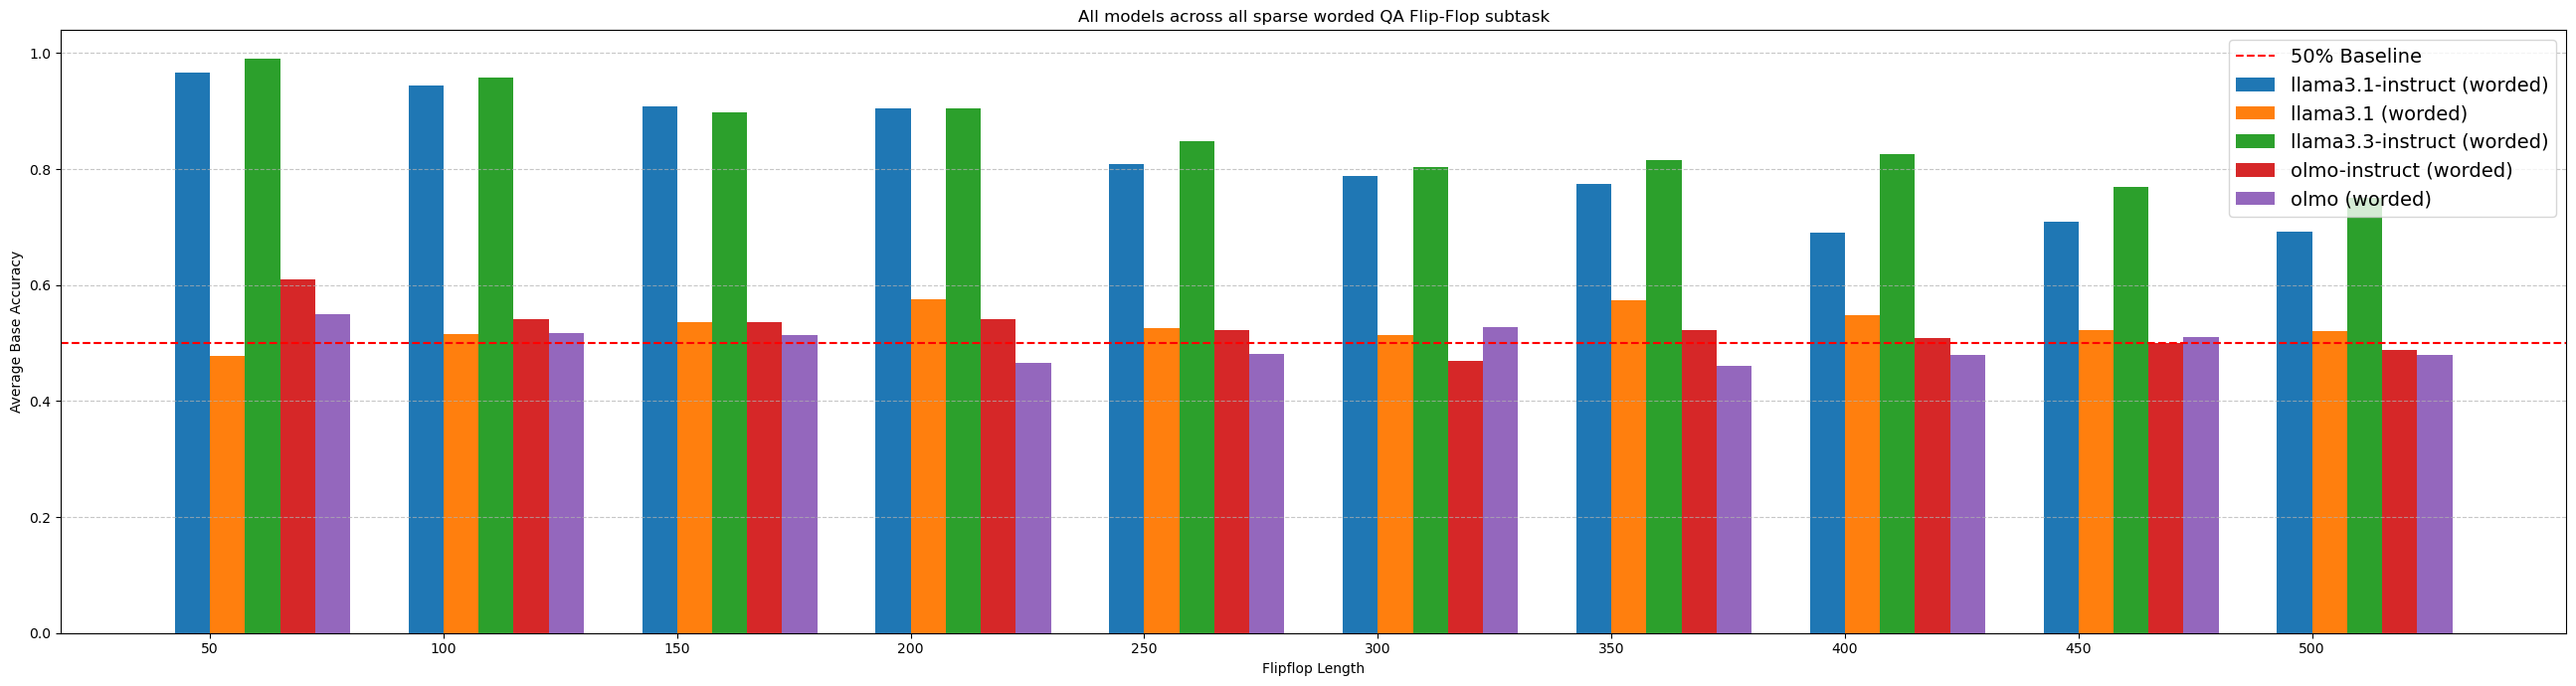

In [8]:
# SPARSE QA WORDED
models = {
    "llama3.1-instruct (worded)": ["llama3.1_70B-instruct/sparse-qa-worded/s1", 
                          "llama3.1_70B-instruct/sparse-qa-worded/s2", 
                          "llama3.1_70B-instruct/sparse-qa-worded/s3", 
                          "llama3.1_70B-instruct/sparse-qa-worded/s4", 
                          "llama3.1_70B-instruct/sparse-qa-worded/s5"],
    "llama3.1 (worded)": ["llama3.1_70B/sparse-qa-worded/s1", 
                 "llama3.1_70B/sparse-qa-worded/s2", 
                 "llama3.1_70B/sparse-qa-worded/s3", 
                 "llama3.1_70B/sparse-qa-worded/s4", 
                 "llama3.1_70B/sparse-qa-worded/s5"],
        "llama3.3-instruct (worded)": ["llama3.3_70B-instruct/sparse-qa-worded/s1", 
                 "llama3.3_70B-instruct/sparse-qa-worded/s2", 
                 "llama3.3_70B-instruct/sparse-qa-worded/s3", 
                 "llama3.3_70B-instruct/sparse-qa-worded/s4", 
                 "llama3.3_70B-instruct/sparse-qa-worded/s5"],
    "olmo-instruct (worded)": ["OLMo_7B-instruct/sparse-qa-worded/s1", 
                         "OLMo_7B-instruct/sparse-qa-worded/s2",
                         "OLMo_7B-instruct/sparse-qa-worded/s3",
                         "OLMo_7B-instruct/sparse-qa-worded/s4",
                         "OLMo_7B-instruct/sparse-qa-worded/s5"],
    "olmo (worded)": ["OLMo_7B/sparse-qa-worded/s1", 
            "OLMo_7B/sparse-qa-worded/s2",
            "OLMo_7B/sparse-qa-worded/s3",
            "OLMo_7B/sparse-qa-worded/s4",
            "OLMo_7B/sparse-qa-worded/s5"],
}


title = "All models across all sparse worded QA Flip-Flop subtask"
output_path = 'graphs/models_across_sparse_worded_qa_flipflop.png'

plot_model_accuracy(models, title, output_path)

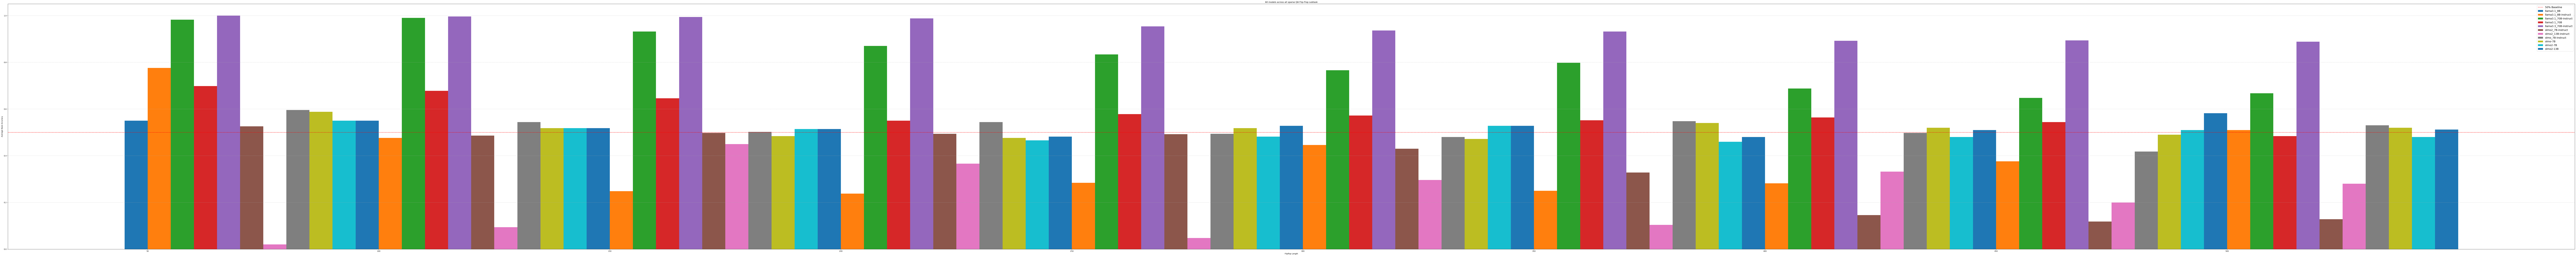

In [9]:
# SPARSE QA
models = {
    "llama3.1_8B": ["llama3.1_8B/sparse-qa/s1", 
                 "llama3.1_8B/sparse-qa/s2", 
                 "llama3.1_8B/sparse-qa/s3", 
                 "llama3.1_8B/sparse-qa/s4", 
                 "llama3.1_8B/sparse-qa/s5"],
    "llama3.1_8B-instruct": ["llama3.1_8B-instruct/sparse-qa/s1", 
                          "llama3.1_8B-instruct/sparse-qa/s2", 
                          "llama3.1_8B-instruct/sparse-qa/s3", 
                          "llama3.1_8B-instruct/sparse-qa/s4", 
                          "llama3.1_8B-instruct/sparse-qa/s5"],
    "llama3.1_70B-instruct": ["llama3.1_70B-instruct/sparse-qa/s1", 
                          "llama3.1_70B-instruct/sparse-qa/s2", 
                          "llama3.1_70B-instruct/sparse-qa/s3", 
                          "llama3.1_70B-instruct/sparse-qa/s4", 
                          "llama3.1_70B-instruct/sparse-qa/s5"],
    "llama3.1_70B": ["llama3.1_70B/sparse-qa/s1", 
                 "llama3.1_70B/sparse-qa/s2", 
                 "llama3.1_70B/sparse-qa/s3", 
                 "llama3.1_70B/sparse-qa/s4", 
                 "llama3.1_70B/sparse-qa/s5"],
        "llama3.3_70B-instruct": ["llama3.3_70B-instruct/sparse-qa/s1", 
                 "llama3.3_70B-instruct/sparse-qa/s2", 
                 "llama3.3_70B-instruct/sparse-qa/s3", 
                 "llama3.3_70B-instruct/sparse-qa/s4", 
                 "llama3.3_70B-instruct/sparse-qa/s5"],
    "olmo2_7B-instruct": ["OLMo2_7B-instruct/sparse-qa/s1", 
                         "OLMo2_7B-instruct/sparse-qa/s2",
                         "OLMo2_7B-instruct/sparse-qa/s3",
                         "OLMo2_7B-instruct/sparse-qa/s4",
                         "OLMo2_7B-instruct/sparse-qa/s5"],
    "olmo2_13B-instruct": ["OLMo2_13B-instruct/sparse-qa/s1", 
                         "OLMo2_13B-instruct/sparse-qa/s2",
                         "OLMo2_13B-instruct/sparse-qa/s3",
                         "OLMo2_13B-instruct/sparse-qa/s4",
                         "OLMo2_13B-instruct/sparse-qa/s5"],
    "olmo_7B-instruct": ["OLMo_7B-instruct/sparse-qa/s1", 
                         "OLMo_7B-instruct/sparse-qa/s2",
                         "OLMo_7B-instruct/sparse-qa/s3",
                         "OLMo_7B-instruct/sparse-qa/s4",
                         "OLMo_7B-instruct/sparse-qa/s5"],
    "olmo-7B": ["OLMo_7B/sparse-qa/s1", 
            "OLMo_7B/sparse-qa/s2",
            "OLMo_7B/sparse-qa/s3",
            "OLMo_7B/sparse-qa/s4",
            "OLMo_7B/sparse-qa/s5"],
    "olmo2-7B": ["OLMo2_7B/sparse-qa/s1", 
            "OLMo2_7B/sparse-qa/s2",
            "OLMo2_7B/sparse-qa/s3",
            "OLMo2_7B/sparse-qa/s4",
            "OLMo2_7B/sparse-qa/s5"],
    "olmo2-13B": ["OLMo2_13B/sparse-qa/s1", 
            "OLMo2_13B/sparse-qa/s2",
            "OLMo2_13B/sparse-qa/s3",
            "OLMo2_13B/sparse-qa/s4",
            "OLMo2_13B/sparse-qa/s5"],
}
title = "All models across all sparse QA Flip-Flop subtask"
output_path = "graphs/models_across_sparse_qa_flipflop.png"
# this plot is unreadable
plot_model_accuracy(models, title, output_path, fig_width=200, fig_height=20, bar_width=0.1)

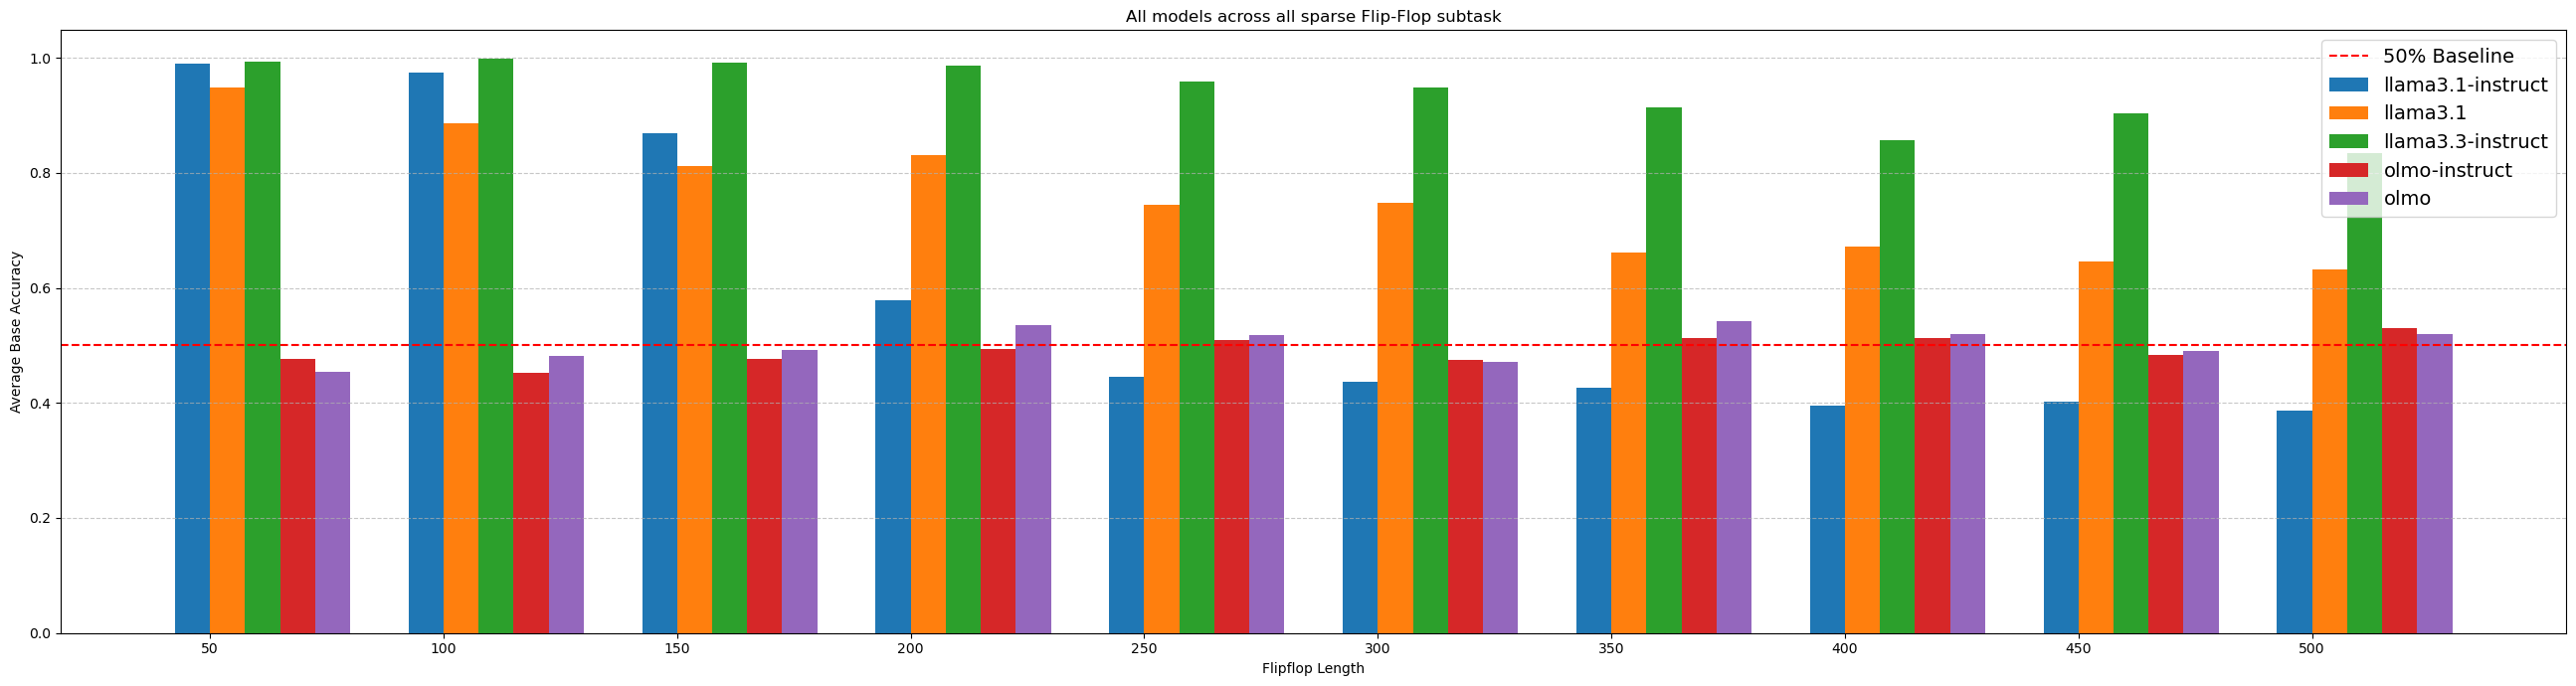

In [10]:
# SPARSE

models = {
    "llama3.1-instruct": ["llama3.1_70B-instruct/sparse/s1", 
                          "llama3.1_70B-instruct/sparse/s2", 
                          "llama3.1_70B-instruct/sparse/s3", 
                          "llama3.1_70B-instruct/sparse/s4", 
                          "llama3.1_70B-instruct/sparse/s5"],
    "llama3.1": ["llama3.1_70B/sparse/s1", 
                 "llama3.1_70B/sparse/s2", 
                 "llama3.1_70B/sparse/s3", 
                 "llama3.1_70B/sparse/s4", 
                 "llama3.1_70B/sparse/s5"],
        "llama3.3-instruct": ["llama3.3_70B-instruct/sparse/s1", 
                 "llama3.3_70B-instruct/sparse/s2", 
                 "llama3.3_70B-instruct/sparse/s3", 
                 "llama3.3_70B-instruct/sparse/s4", 
                 "llama3.3_70B-instruct/sparse/s5"],
    "olmo-instruct": ["OLMo_7B-instruct/sparse/s1", 
                         "OLMo_7B-instruct/sparse/s2",
                         "OLMo_7B-instruct/sparse/s3",
                         "OLMo_7B-instruct/sparse/s4",
                         "OLMo_7B-instruct/sparse/s5"],
    "olmo": ["OLMo_7B/sparse/s1", 
            "OLMo_7B/sparse/s2",
            "OLMo_7B/sparse/s3",
            "OLMo_7B/sparse/s4",
            "OLMo_7B/sparse/s5"],
}


title = "All models across all sparse Flip-Flop subtask"
output_path = "graphs/models_across_sparse_flipflop.png"
plot_model_accuracy(models, title, output_path)

# Llama 3.1 70B on all sparse subtasks

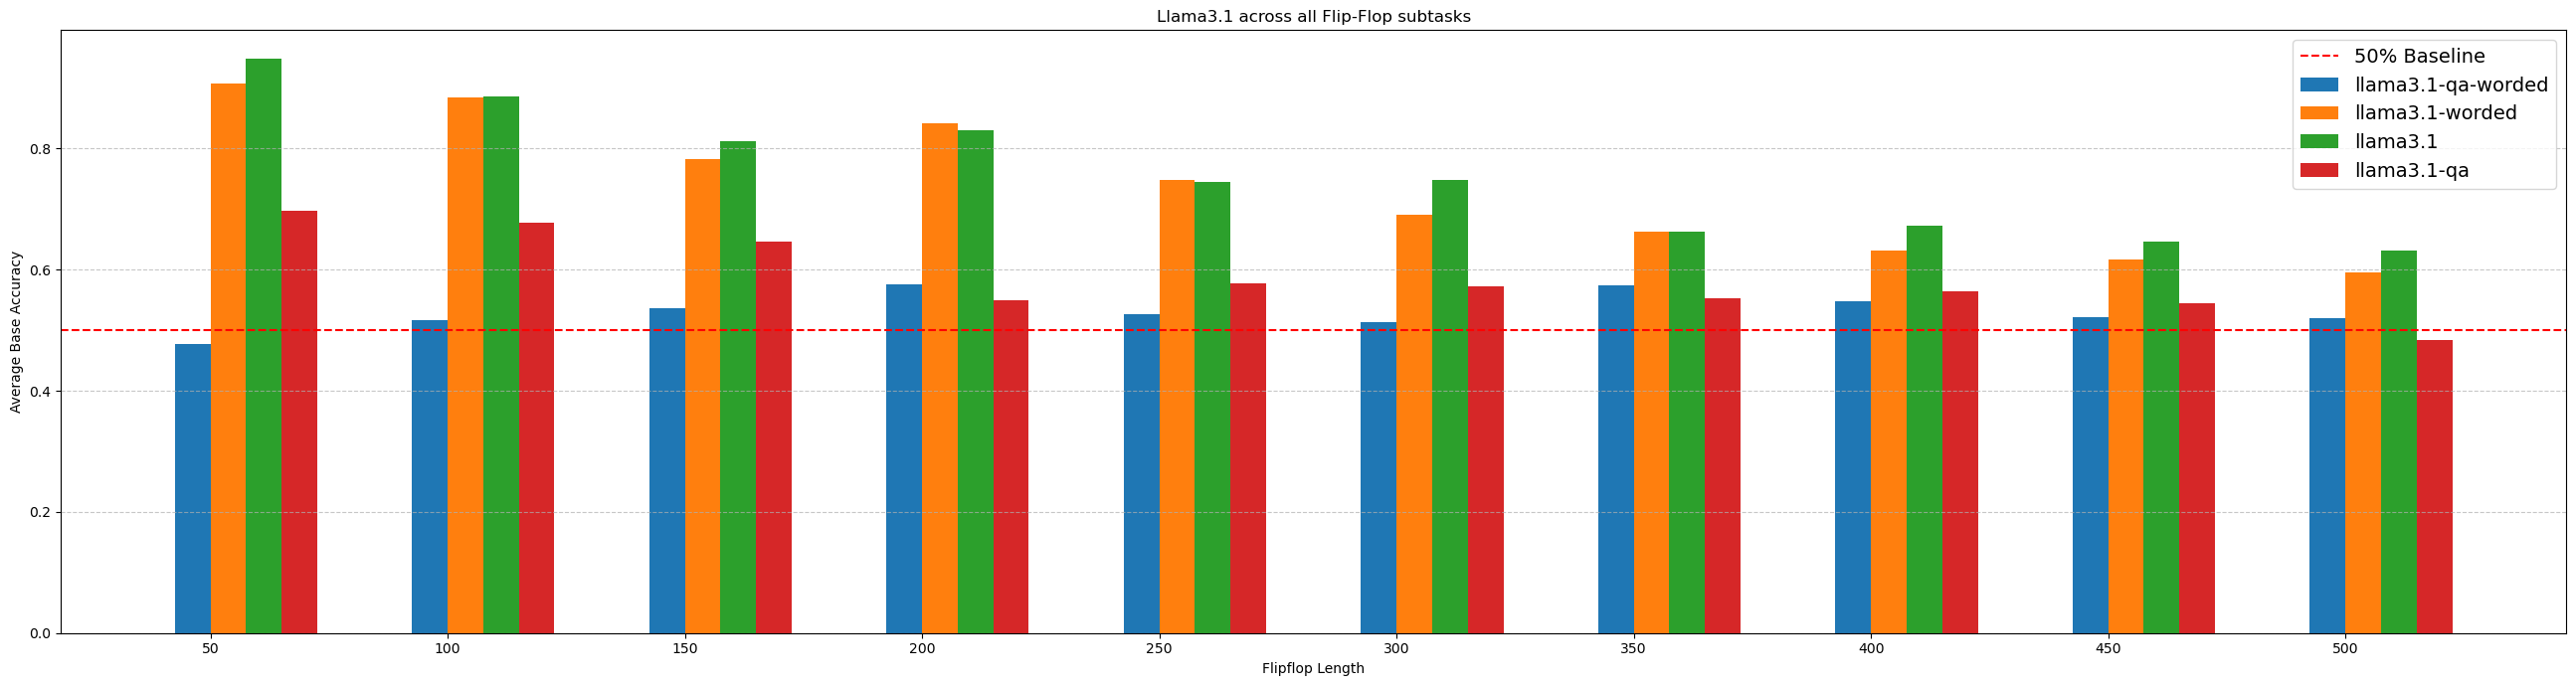

In [42]:
models = {
    "llama3.1-qa-worded": ["llama3.1_70B/sparse-qa-worded/s1", 
                          "llama3.1_70B/sparse-qa-worded/s2", 
                          "llama3.1_70B/sparse-qa-worded/s3", 
                          "llama3.1_70B/sparse-qa-worded/s4", 
                          "llama3.1_70B/sparse-qa-worded/s5"],
    "llama3.1-worded": ["llama3.1_70B/sparse-worded/s1", 
                 "llama3.1_70B/sparse-worded/s2", 
                 "llama3.1_70B/sparse-worded/s3", 
                 "llama3.1_70B/sparse-worded/s4", 
                 "llama3.1_70B/sparse-worded/s5"],
    "llama3.1": ["llama3.1_70B/sparse/s1", 
                 "llama3.1_70B/sparse/s2", 
                 "llama3.1_70B/sparse/s3", 
                 "llama3.1_70B/sparse/s4", 
                 "llama3.1_70B/sparse/s5"],
    "llama3.1-qa": ["llama3.1_70B/sparse-qa/s1", 
                 "llama3.1_70B/sparse-qa/s2", 
                 "llama3.1_70B/sparse-qa/s3", 
                 "llama3.1_70B/sparse-qa/s4", 
                 "llama3.1_70B/sparse-qa/s5"],
}
title = "Llama3.1 across all Flip-Flop subtasks"
output_path = "graphs/llama3.1_across_sparse_flipflop.png"
plot_model_accuracy(models, title, output_path)

# OLMo 7B on all substasks

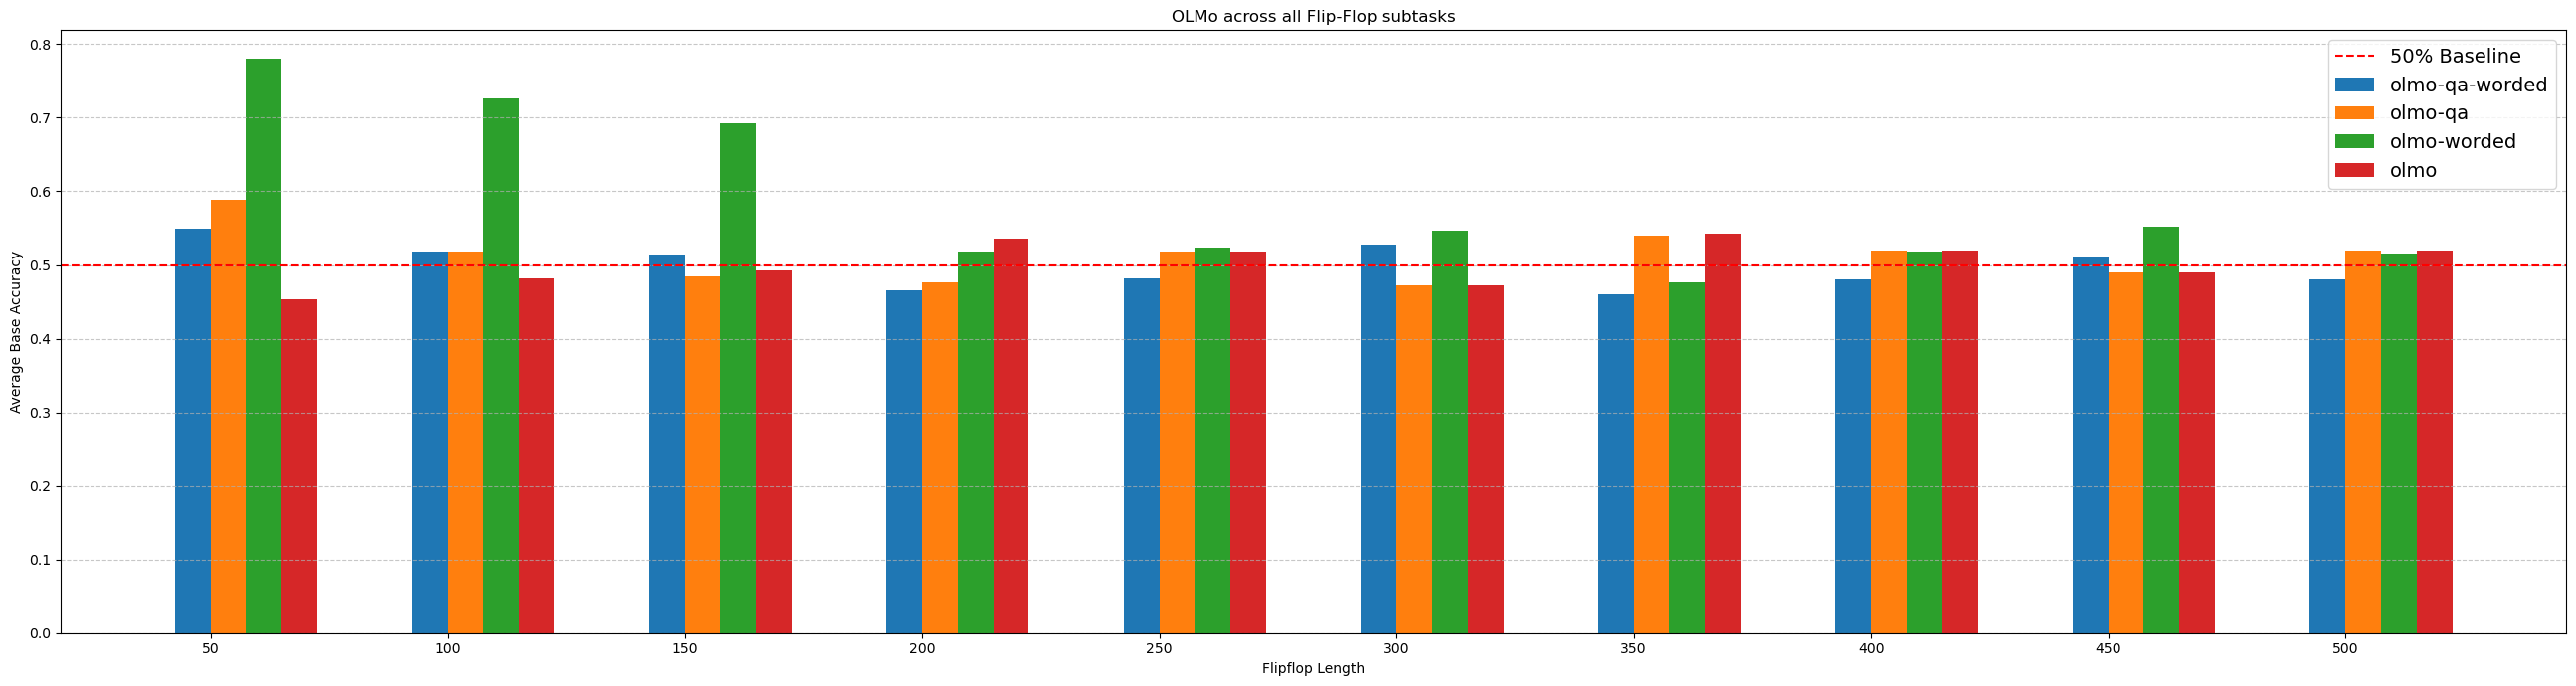

In [43]:
models = {
    "olmo-qa-worded": ["OLMo_7B/sparse-qa-worded/s1", 
                          "OLMo_7B/sparse-qa-worded/s2", 
                          "OLMo_7B/sparse-qa-worded/s3", 
                          "OLMo_7B/sparse-qa-worded/s4", 
                          "OLMo_7B/sparse-qa-worded/s5"],
    "olmo-qa": ["OLMo_7B/sparse-qa/s1", 
                          "OLMo_7B/sparse-qa/s2", 
                          "OLMo_7B/sparse-qa/s3", 
                          "OLMo_7B/sparse-qa/s4", 
                          "OLMo_7B/sparse-qa/s5"],
    "olmo-worded": ["OLMo_7B/sparse-worded/s1", 
                          "OLMo_7B/sparse-worded/s2", 
                          "OLMo_7B/sparse-worded/s3", 
                          "OLMo_7B/sparse-worded/s4", 
                          "OLMo_7B/sparse-worded/s5"],
    "olmo": ["OLMo_7B/sparse/s1", 
                          "OLMo_7B/sparse/s2", 
                          "OLMo_7B/sparse/s3", 
                          "OLMo_7B/sparse/s4", 
                          "OLMo_7B/sparse/s5"],
}


title = "OLMo across all Flip-Flop subtasks"
output_path = "graphs/olmo_across_sparse_flipflop.png"
plot_model_accuracy(models, title, output_path)

# OLMo-instruct 7B on all subtasks

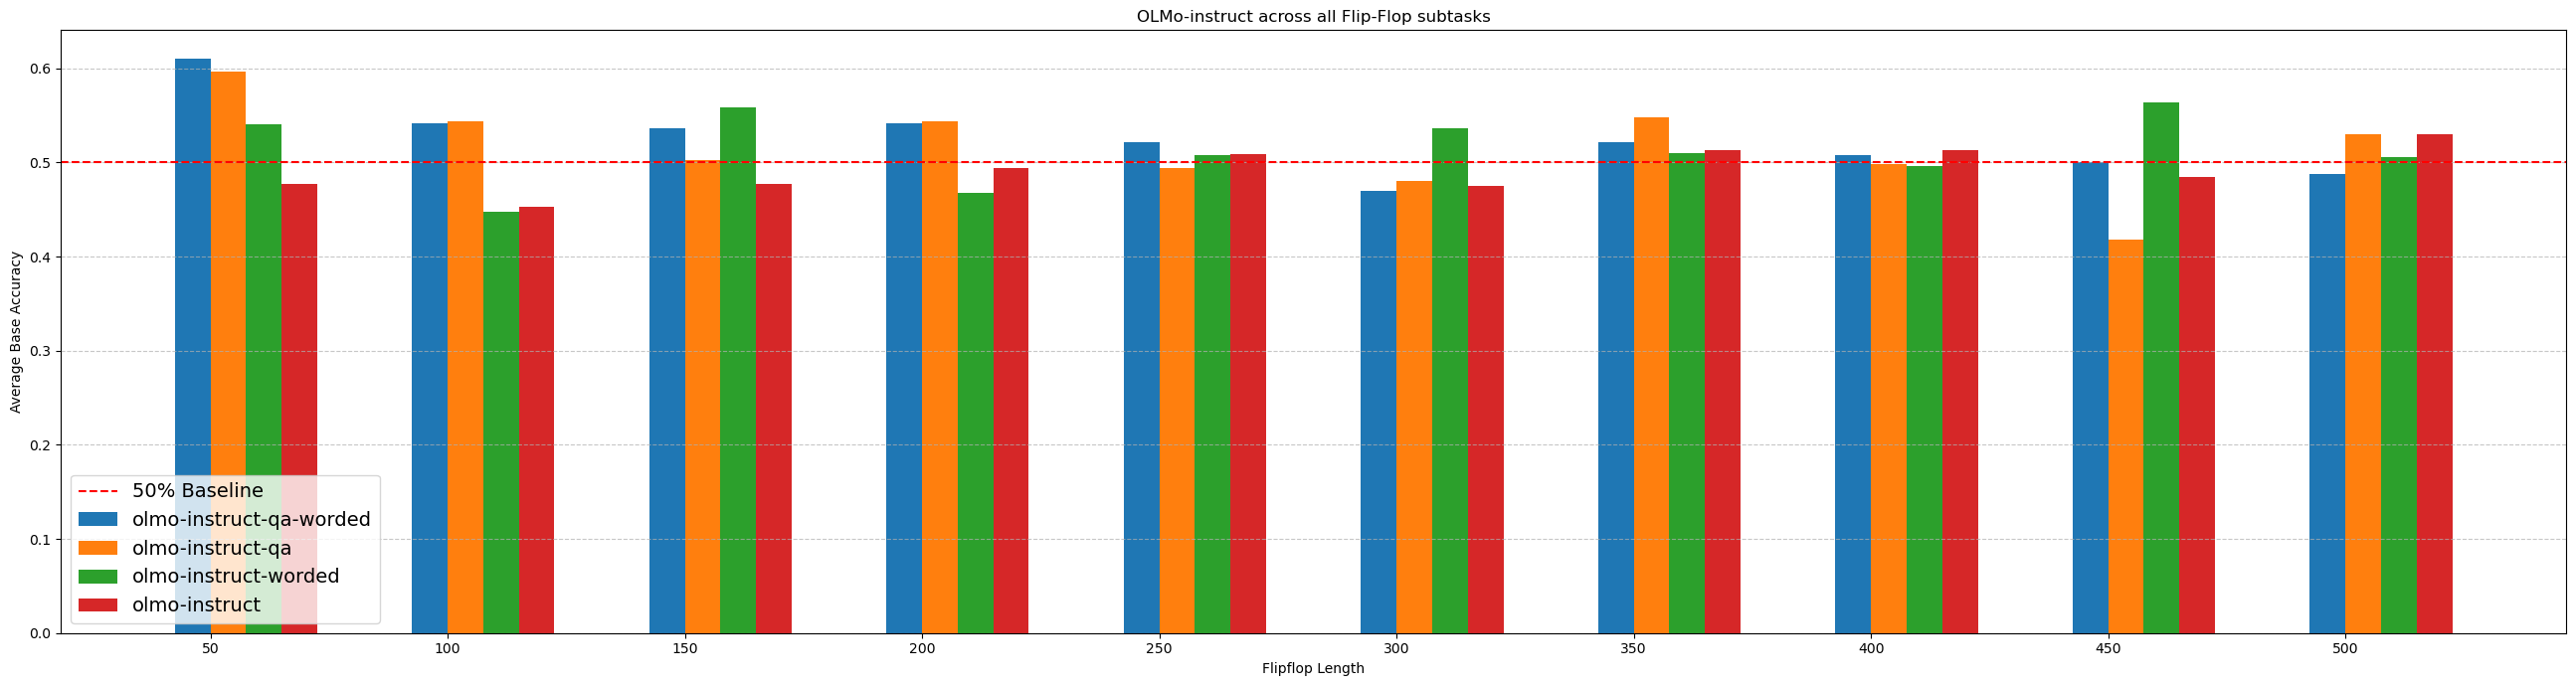

In [44]:
models = {
    "olmo-instruct-qa-worded": ["OLMo_7B-instruct/sparse-qa-worded/s1", 
                          "OLMo_7B-instruct/sparse-qa-worded/s2", 
                          "OLMo_7B-instruct/sparse-qa-worded/s3", 
                          "OLMo_7B-instruct/sparse-qa-worded/s4", 
                          "OLMo_7B-instruct/sparse-qa-worded/s5"],
    "olmo-instruct-qa": ["OLMo_7B-instruct/sparse-qa/s1", 
                          "OLMo_7B-instruct/sparse-qa/s2", 
                          "OLMo_7B-instruct/sparse-qa/s3", 
                          "OLMo_7B-instruct/sparse-qa/s4", 
                          "OLMo_7B-instruct/sparse-qa/s5"],
    "olmo-instruct-worded": ["OLMo_7B-instruct/sparse-worded/s1", 
                          "OLMo_7B-instruct/sparse-worded/s2", 
                          "OLMo_7B-instruct/sparse-worded/s3", 
                          "OLMo_7B-instruct/sparse-worded/s4", 
                          "OLMo_7B-instruct/sparse-worded/s5"],
    "olmo-instruct": ["OLMo_7B-instruct/sparse/s1", 
                          "OLMo_7B-instruct/sparse/s2", 
                          "OLMo_7B-instruct/sparse/s3", 
                          "OLMo_7B-instruct/sparse/s4", 
                          "OLMo_7B-instruct/sparse/s5"],
}


title = "OLMo-instruct across all Flip-Flop subtasks"
output_path = "graphs/olmo-instruct_across_sparse_flipflop.png"
plot_model_accuracy(models, title, output_path)

# Llama 3.1-instruct 70B on all subtasks

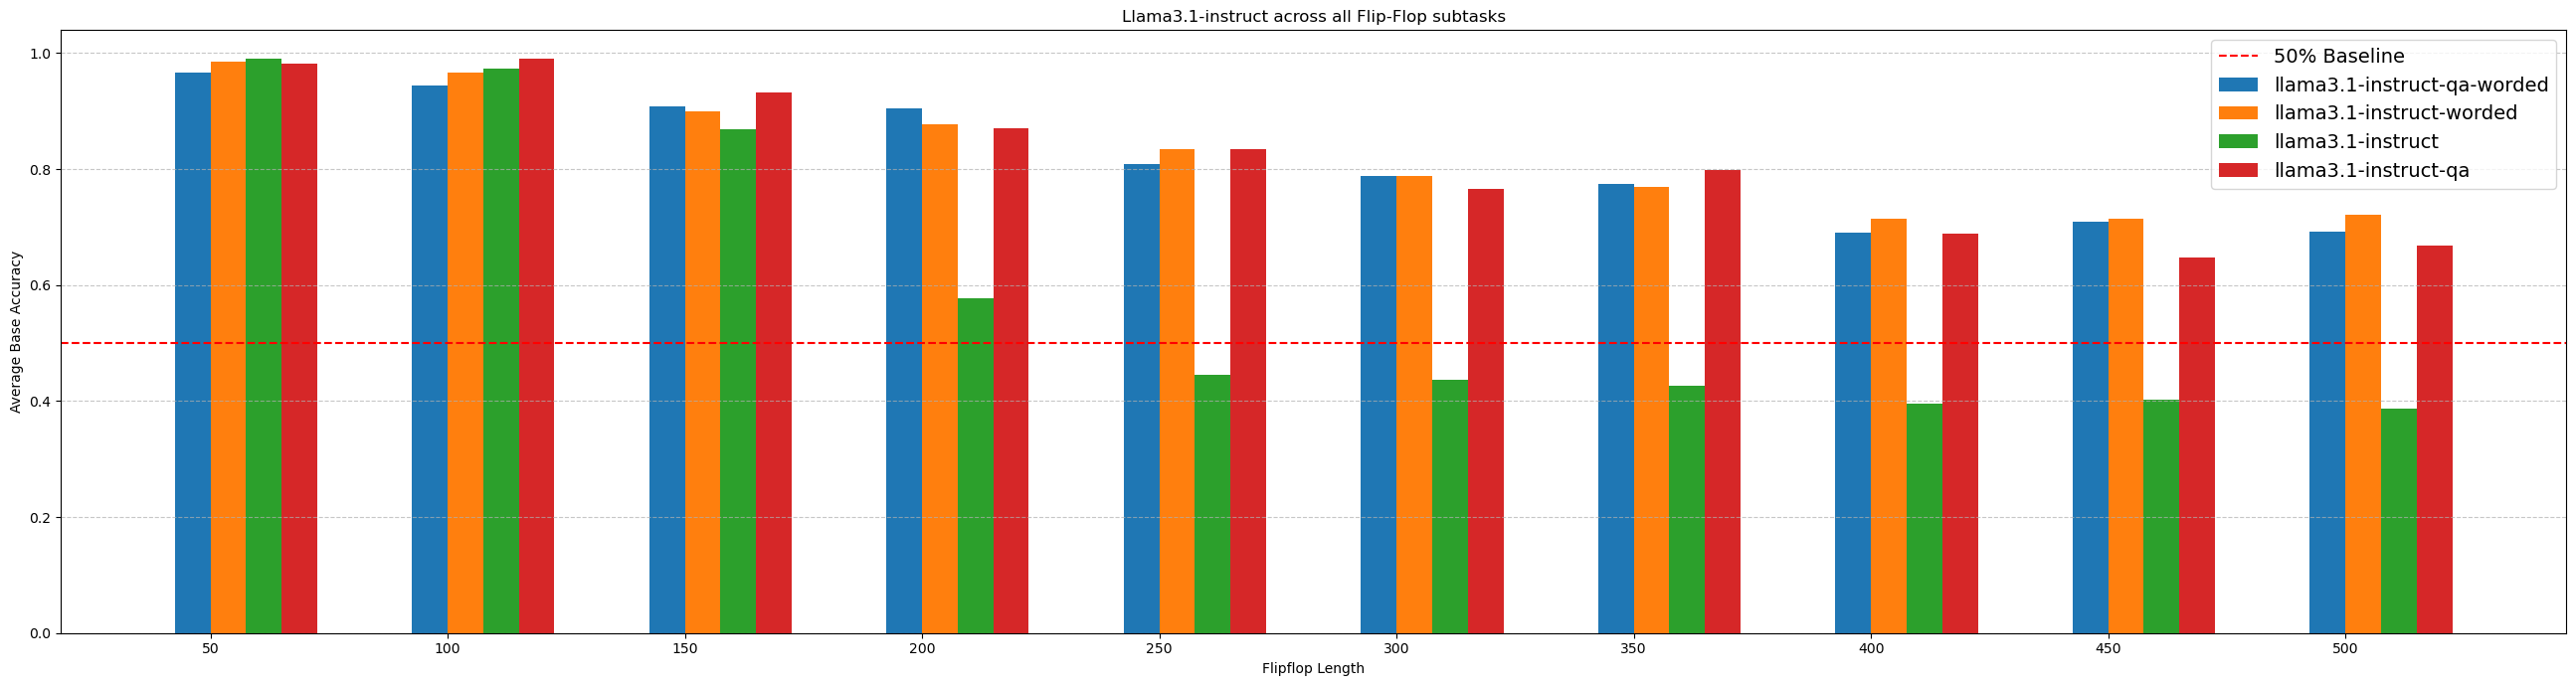

In [45]:
models = {
    "llama3.1-instruct-qa-worded": ["llama3.1_70B-instruct/sparse-qa-worded/s1", 
                          "llama3.1_70B-instruct/sparse-qa-worded/s2", 
                          "llama3.1_70B-instruct/sparse-qa-worded/s3", 
                          "llama3.1_70B-instruct/sparse-qa-worded/s4", 
                          "llama3.1_70B-instruct/sparse-qa-worded/s5"],
    "llama3.1-instruct-worded": ["llama3.1_70B-instruct/sparse-worded/s1", 
                 "llama3.1_70B-instruct/sparse-worded/s2", 
                 "llama3.1_70B-instruct/sparse-worded/s3", 
                 "llama3.1_70B-instruct/sparse-worded/s4", 
                 "llama3.1_70B-instruct/sparse-worded/s5"],
    "llama3.1-instruct": ["llama3.1_70B-instruct/sparse/s1", 
                 "llama3.1_70B-instruct/sparse/s2", 
                 "llama3.1_70B-instruct/sparse/s3", 
                 "llama3.1_70B-instruct/sparse/s4", 
                 "llama3.1_70B-instruct/sparse/s5"],
    "llama3.1-instruct-qa": ["llama3.1_70B-instruct/sparse-qa/s1", 
                 "llama3.1_70B-instruct/sparse-qa/s2", 
                 "llama3.1_70B-instruct/sparse-qa/s3", 
                 "llama3.1_70B-instruct/sparse-qa/s4", 
                 "llama3.1_70B-instruct/sparse-qa/s5"],
}
title = "Llama3.1-instruct across all Flip-Flop subtasks"
output_path = "graphs/llama3.1-instruct_across_sparse_flipflop.png"
plot_model_accuracy(models, title, output_path)

# Llama 3.3-instruct 70B on all subtasks

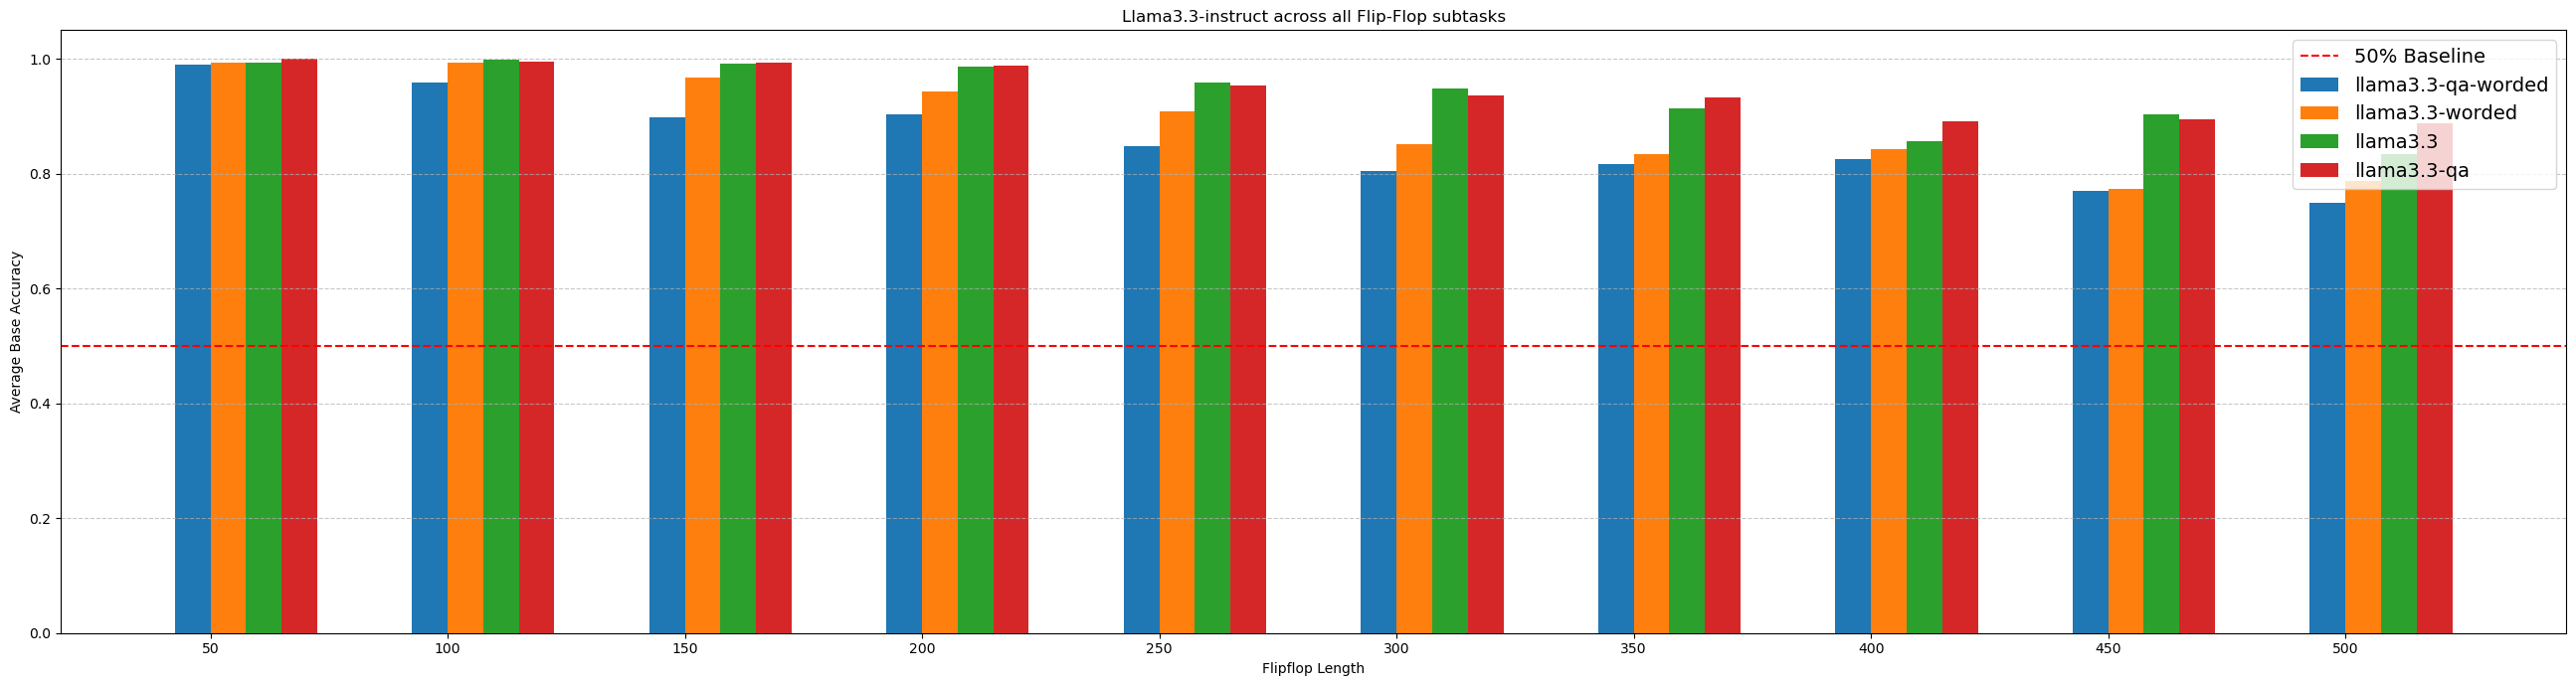

In [91]:
models = {
    "llama3.3-qa-worded": ["llama3.3_70B-instruct/sparse-qa-worded/s1", 
                          "llama3.3_70B-instruct/sparse-qa-worded/s2", 
                          "llama3.3_70B-instruct/sparse-qa-worded/s3", 
                          "llama3.3_70B-instruct/sparse-qa-worded/s4", 
                          "llama3.3_70B-instruct/sparse-qa-worded/s5"],
    "llama3.3-worded": ["llama3.3_70B-instruct/sparse-worded/s1", 
                 "llama3.3_70B-instruct/sparse-worded/s2", 
                 "llama3.3_70B-instruct/sparse-worded/s3", 
                 "llama3.3_70B-instruct/sparse-worded/s4", 
                 "llama3.3_70B-instruct/sparse-worded/s5"],
    "llama3.3": ["llama3.3_70B-instruct/sparse/s1", 
                 "llama3.3_70B-instruct/sparse/s2", 
                 "llama3.3_70B-instruct/sparse/s3", 
                 "llama3.3_70B-instruct/sparse/s4", 
                 "llama3.3_70B-instruct/sparse/s5"],
    "llama3.3-qa": ["llama3.3_70B-instruct/sparse-qa/s1", 
                 "llama3.3_70B-instruct/sparse-qa/s2", 
                 "llama3.3_70B-instruct/sparse-qa/s3", 
                 "llama3.3_70B-instruct/sparse-qa/s4", 
                 "llama3.3_70B-instruct/sparse-qa/s5"],
}
title = "Llama3.3-instruct across all Flip-Flop subtasks"
output_path = "graphs/llama3.3-instruct_across_sparse_flipflop.png"
plot_model_accuracy(models, title, output_path)

# All Llamas together

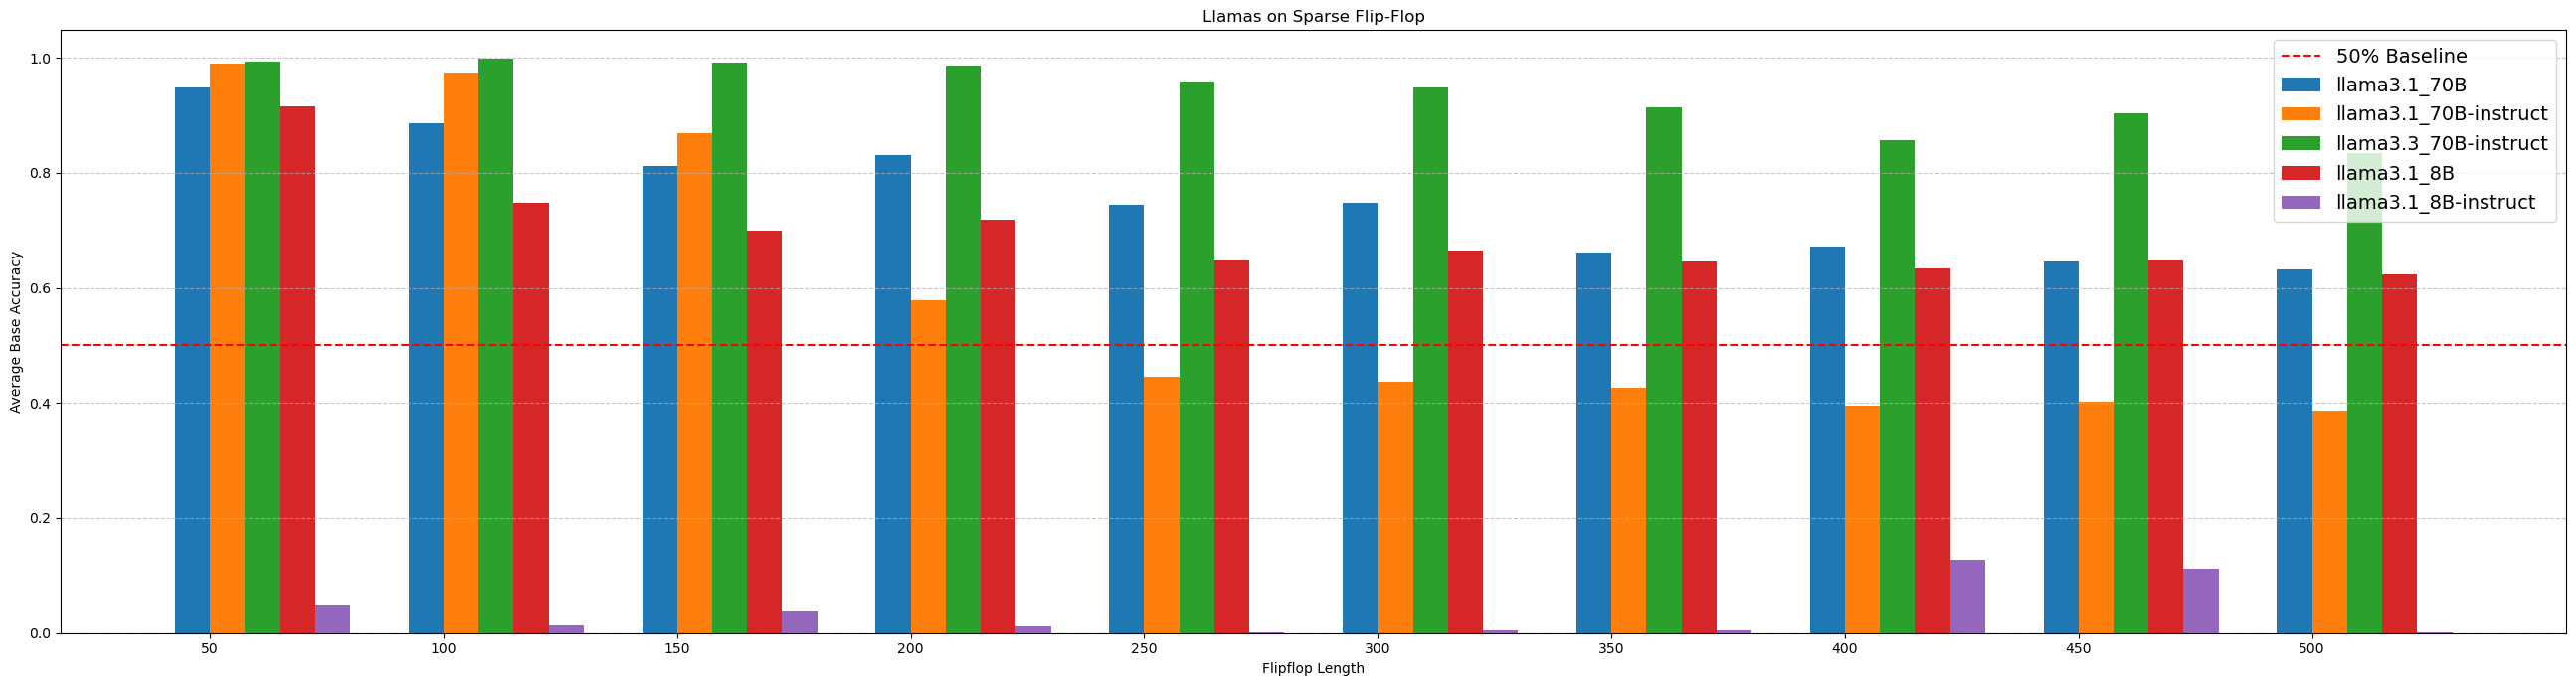

In [18]:
# SPARSE
models = {
    "llama3.1_70B": ["llama3.1_70B/sparse/s1", 
                          "llama3.1_70B/sparse/s2", 
                          "llama3.1_70B/sparse/s3", 
                          "llama3.1_70B/sparse/s4", 
                          "llama3.1_70B/sparse/s5"],
    "llama3.1_70B-instruct": ["llama3.1_70B-instruct/sparse/s1", 
                 "llama3.1_70B-instruct/sparse/s2", 
                 "llama3.1_70B-instruct/sparse/s3", 
                 "llama3.1_70B-instruct/sparse/s4", 
                 "llama3.1_70B-instruct/sparse/s5"],
    "llama3.3_70B-instruct": ["llama3.3_70B-instruct/sparse/s1", 
                 "llama3.3_70B-instruct/sparse/s2", 
                 "llama3.3_70B-instruct/sparse/s3", 
                 "llama3.3_70B-instruct/sparse/s4", 
                 "llama3.3_70B-instruct/sparse/s5"],
        "llama3.1_8B": ["llama3.1_8B/sparse/s1", 
                 "llama3.1_8B/sparse/s2", 
                 "llama3.1_8B/sparse/s3", 
                 "llama3.1_8B/sparse/s4", 
                 "llama3.1_8B/sparse/s5"],
    "llama3.1_8B-instruct": ["llama3.1_8B-instruct/sparse/s1", 
                          "llama3.1_8B-instruct/sparse/s2", 
                          "llama3.1_8B-instruct/sparse/s3", 
                          "llama3.1_8B-instruct/sparse/s4", 
                          "llama3.1_8B-instruct/sparse/s5"]
}
title = "Llamas on Sparse Flip-Flop"
output_path = "graphs/llamas_across_sparse_flipflop.png"
plot_model_accuracy(models, title, output_path)

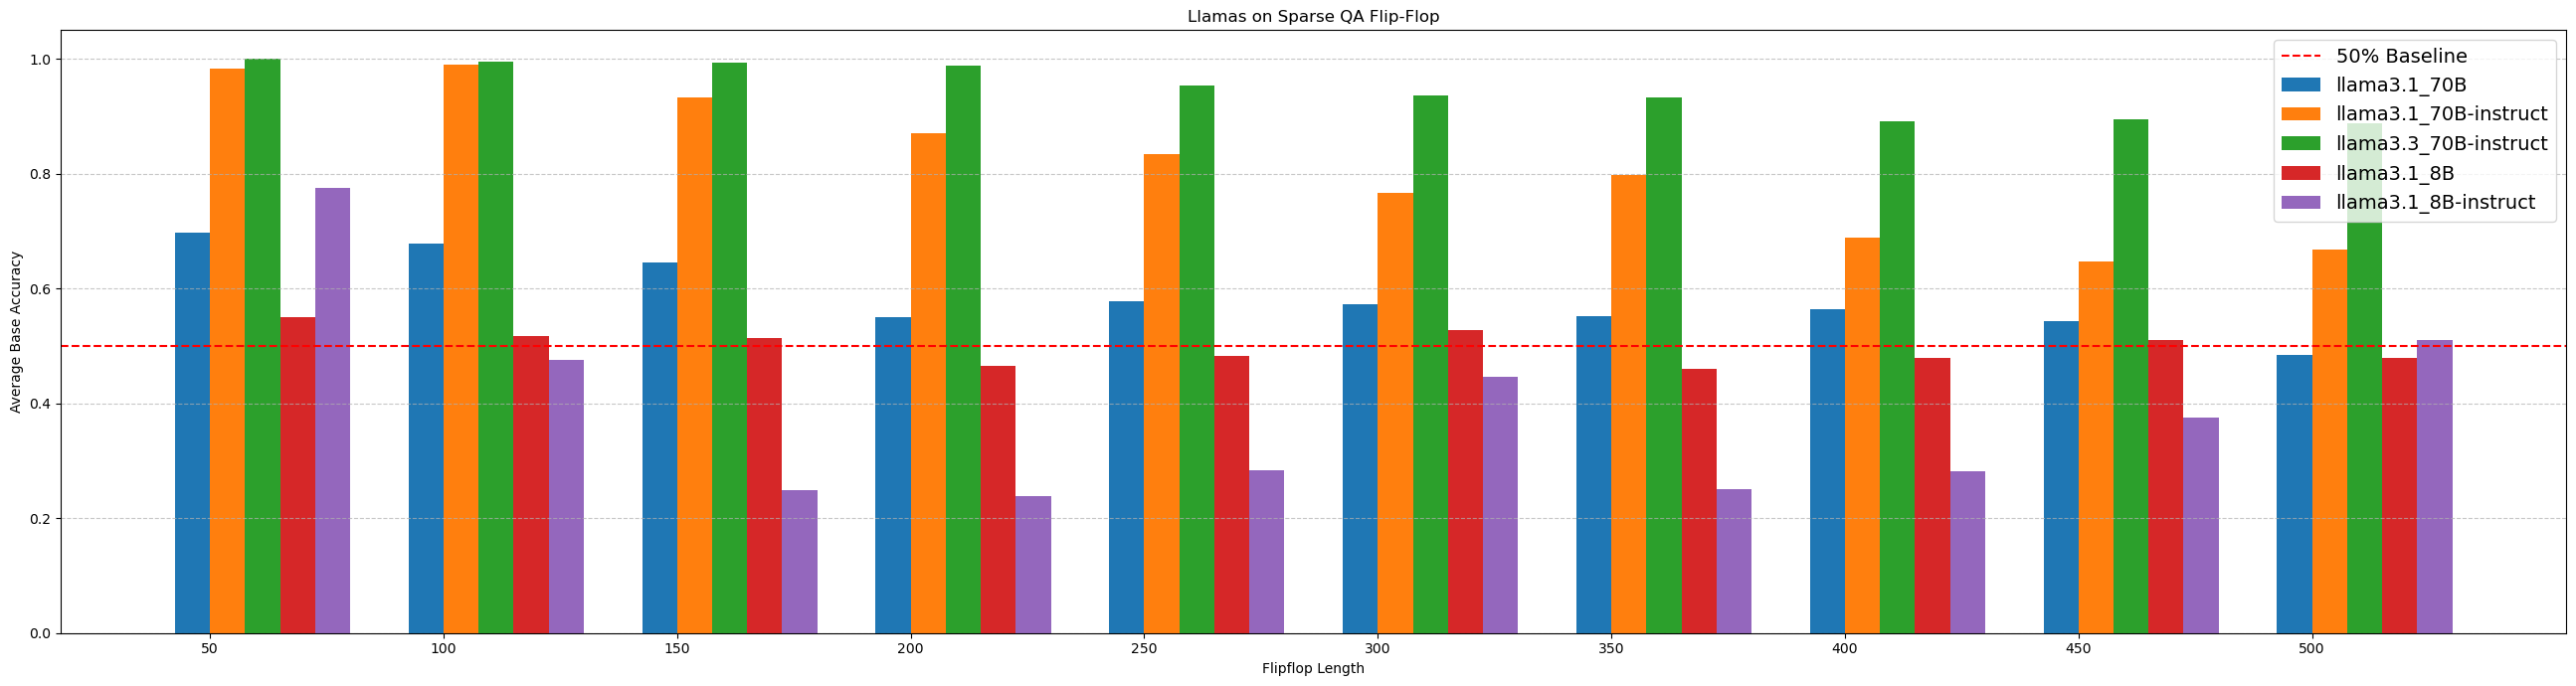

In [19]:
# SPARSE QA
models = {
    "llama3.1_70B": ["llama3.1_70B/sparse-qa/s1", 
                          "llama3.1_70B/sparse-qa/s2", 
                          "llama3.1_70B/sparse-qa/s3", 
                          "llama3.1_70B/sparse-qa/s4", 
                          "llama3.1_70B/sparse-qa/s5"],
    "llama3.1_70B-instruct": ["llama3.1_70B-instruct/sparse-qa/s1", 
                 "llama3.1_70B-instruct/sparse-qa/s2", 
                 "llama3.1_70B-instruct/sparse-qa/s3", 
                 "llama3.1_70B-instruct/sparse-qa/s4", 
                 "llama3.1_70B-instruct/sparse-qa/s5"],
    "llama3.3_70B-instruct": ["llama3.3_70B-instruct/sparse-qa/s1", 
                 "llama3.3_70B-instruct/sparse-qa/s2", 
                 "llama3.3_70B-instruct/sparse-qa/s3", 
                 "llama3.3_70B-instruct/sparse-qa/s4", 
                 "llama3.3_70B-instruct/sparse-qa/s5"],
        "llama3.1_8B": ["llama3.1_8B/sparse-qa/s1", 
                 "llama3.1_8B/sparse-qa/s2", 
                 "llama3.1_8B/sparse-qa/s3", 
                 "llama3.1_8B/sparse-qa/s4", 
                 "llama3.1_8B/sparse-qa/s5"],
    "llama3.1_8B-instruct": ["llama3.1_8B-instruct/sparse-qa/s1", 
                          "llama3.1_8B-instruct/sparse-qa/s2", 
                          "llama3.1_8B-instruct/sparse-qa/s3", 
                          "llama3.1_8B-instruct/sparse-qa/s4", 
                          "llama3.1_8B-instruct/sparse-qa/s5"],
}
title = "Llamas on Sparse QA Flip-Flop"
output_path = "graphs/llamas_across_sparse_qa_flipflop.png"
plot_model_accuracy(models, title, output_path)

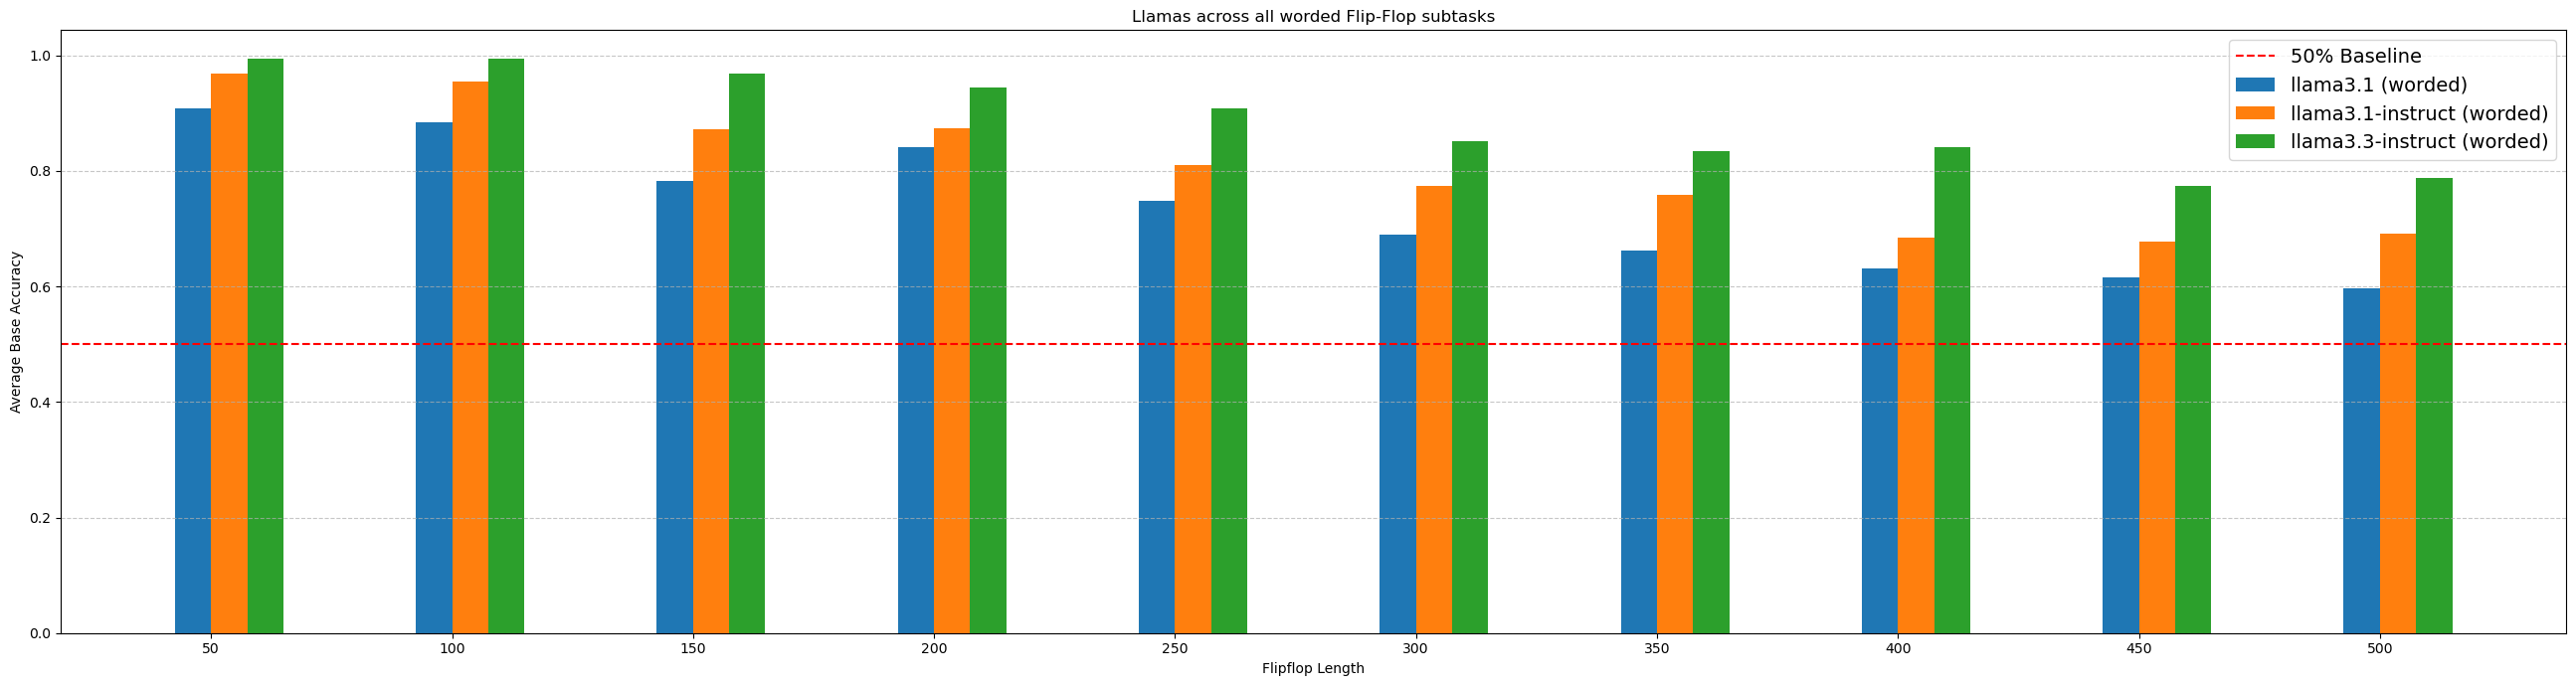

In [49]:
# SPARSE WORDED
models = {
    "llama3.1 (worded)": ["llama3.1_70B/sparse-worded/s1", 
                          "llama3.1_70B/sparse-worded/s2", 
                          "llama3.1_70B/sparse-worded/s3", 
                          "llama3.1_70B/sparse-worded/s4", 
                          "llama3.1_70B/sparse-worded/s5"],
    "llama3.1-instruct (worded)": ["llama3.1_70B/sparse-worded/s1", 
                 "llama3.1_70B-instruct/sparse-worded/s2", 
                 "llama3.1_70B-instruct/sparse-worded/s3", 
                 "llama3.1_70B-instruct/sparse-worded/s4", 
                 "llama3.1_70B-instruct/sparse-worded/s5"],
    "llama3.3-instruct (worded)": ["llama3.3_70B-instruct/sparse-worded/s1", 
                 "llama3.3_70B-instruct/sparse-worded/s2", 
                 "llama3.3_70B-instruct/sparse-worded/s3", 
                 "llama3.3_70B-instruct/sparse-worded/s4", 
                 "llama3.3_70B-instruct/sparse-worded/s5"]
}
title = "Llamas across all worded Flip-Flop subtasks"
output_path = "graphs/llamas_across_sparse_worded_flipflop.png"
plot_model_accuracy(models, title, output_path)

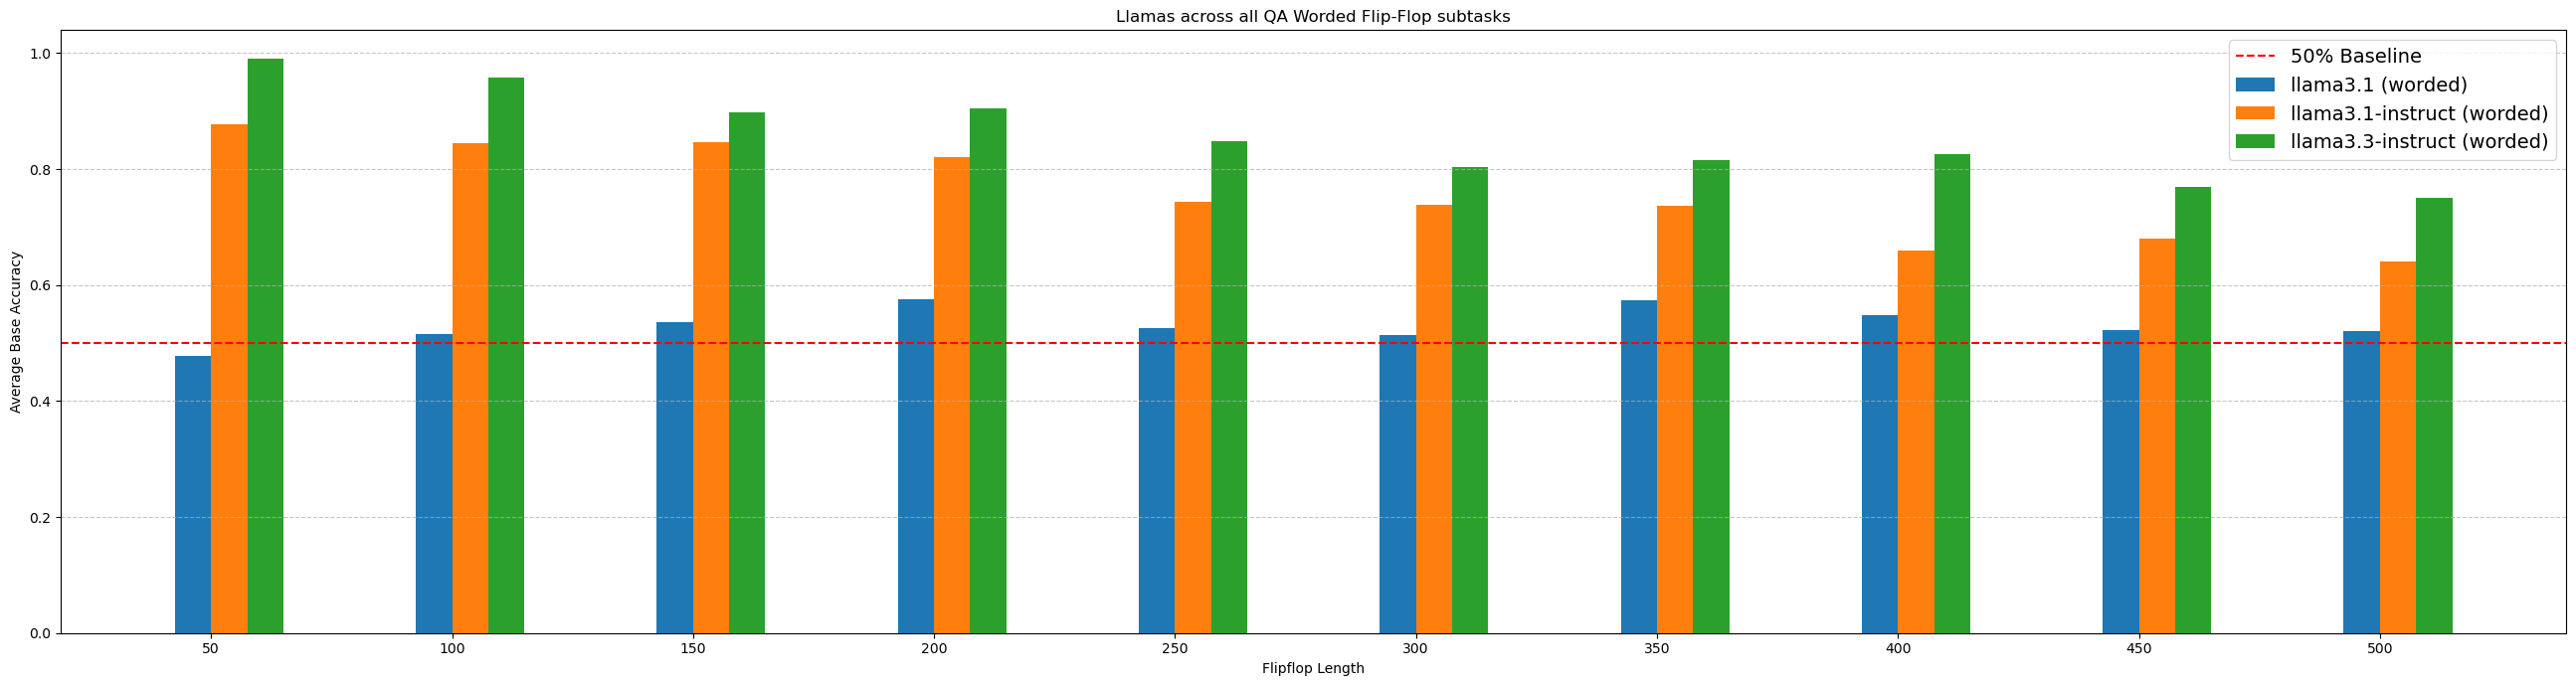

In [50]:
# SPARSE QA WORDED
models = {
    "llama3.1 (worded)": ["llama3.1_70B/sparse-qa-worded/s1", 
                          "llama3.1_70B/sparse-qa-worded/s2", 
                          "llama3.1_70B/sparse-qa-worded/s3", 
                          "llama3.1_70B/sparse-qa-worded/s4", 
                          "llama3.1_70B/sparse-qa-worded/s5"],
    "llama3.1-instruct (worded)": ["llama3.1_70B/sparse-qa-worded/s1", 
                 "llama3.1_70B-instruct/sparse-qa-worded/s2", 
                 "llama3.1_70B-instruct/sparse-qa-worded/s3", 
                 "llama3.1_70B-instruct/sparse-qa-worded/s4", 
                 "llama3.1_70B-instruct/sparse-qa-worded/s5"],
    "llama3.3-instruct (worded)": ["llama3.3_70B-instruct/sparse-qa-worded/s1", 
                 "llama3.3_70B-instruct/sparse-qa-worded/s2", 
                 "llama3.3_70B-instruct/sparse-qa-worded/s3", 
                 "llama3.3_70B-instruct/sparse-qa-worded/s4", 
                 "llama3.3_70B-instruct/sparse-qa-worded/s5"]
}
title = "Llamas across all QA Worded Flip-Flop subtasks"
output_path = "graphs/llamas_across_sparse_qa_worded_flipflop.png"
plot_model_accuracy(models, title, output_path)

# All OLMos together

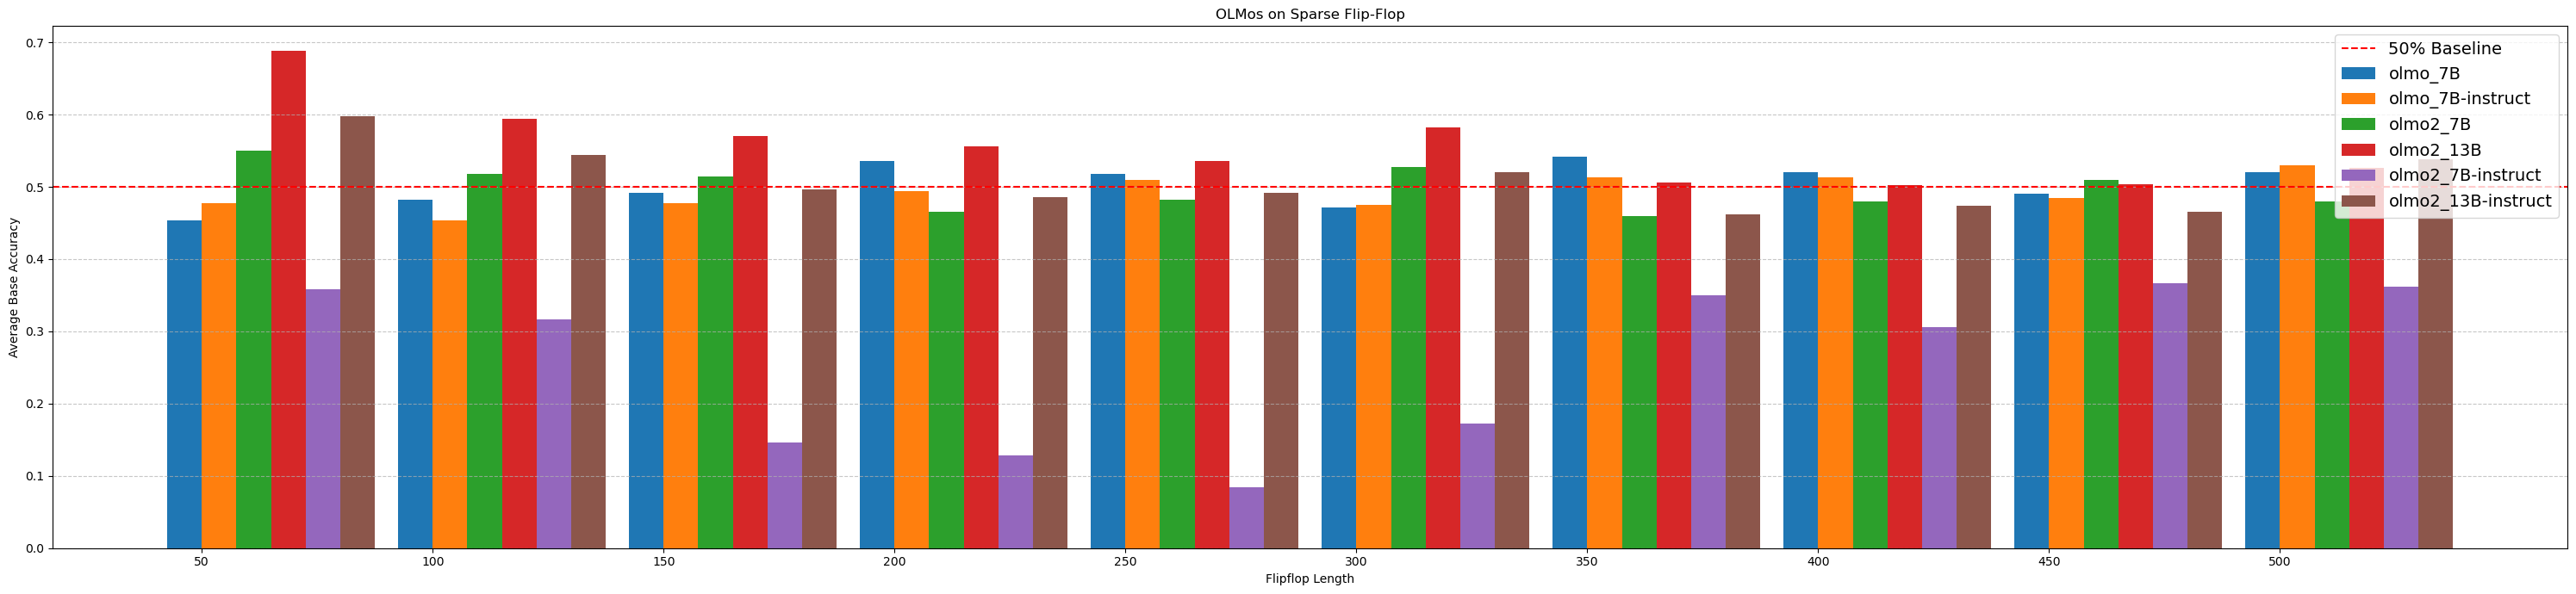

In [20]:
# SPARSE
models = {
    "olmo_7B": ["OLMo_7B/sparse/s1", 
                          "OLMo_7B/sparse/s2", 
                          "OLMo_7B/sparse/s3", 
                          "OLMo_7B/sparse/s4", 
                          "OLMo_7B/sparse/s5"],
    "olmo_7B-instruct": ["OLMo_7B-instruct/sparse/s1", 
                 "OLMo_7B-instruct/sparse/s2", 
                 "OLMo_7B-instruct/sparse/s3", 
                 "OLMo_7B-instruct/sparse/s4", 
                 "OLMo_7B-instruct/sparse/s5"],
        "olmo2_7B": ["OLMo2_7B/sparse/s1", 
            "OLMo2_7B/sparse/s2",
            "OLMo2_7B/sparse/s3",
            "OLMo2_7B/sparse/s4",
            "OLMo2_7B/sparse/s5"],
    "olmo2_13B": ["OLMo2_13B/sparse/s1", 
            "OLMo2_13B/sparse/s2",
            "OLMo2_13B/sparse/s3",
            "OLMo2_13B/sparse/s4",
            "OLMo2_13B/sparse/s5"],
    "olmo2_7B-instruct": ["OLMo2_7B-instruct/sparse/s1", 
            "OLMo2_7B-instruct/sparse/s2",
            "OLMo2_7B-instruct/sparse/s3",
            "OLMo2_7B-instruct/sparse/s4",
            "OLMo2_7B-instruct/sparse/s5"],
    "olmo2_13B-instruct": ["OLMo2_13B-instruct/sparse/s1", 
            "OLMo2_13B-instruct/sparse/s2",
            "OLMo2_13B-instruct/sparse/s3",
            "OLMo2_13B-instruct/sparse/s4",
            "OLMo2_13B-instruct/sparse/s5"]
}
title = "OLMos on Sparse Flip-Flop"
output_path = "graphs/olmos_across_sparse_flipflop.png"
plot_model_accuracy(models, title, output_path, fig_width=30)

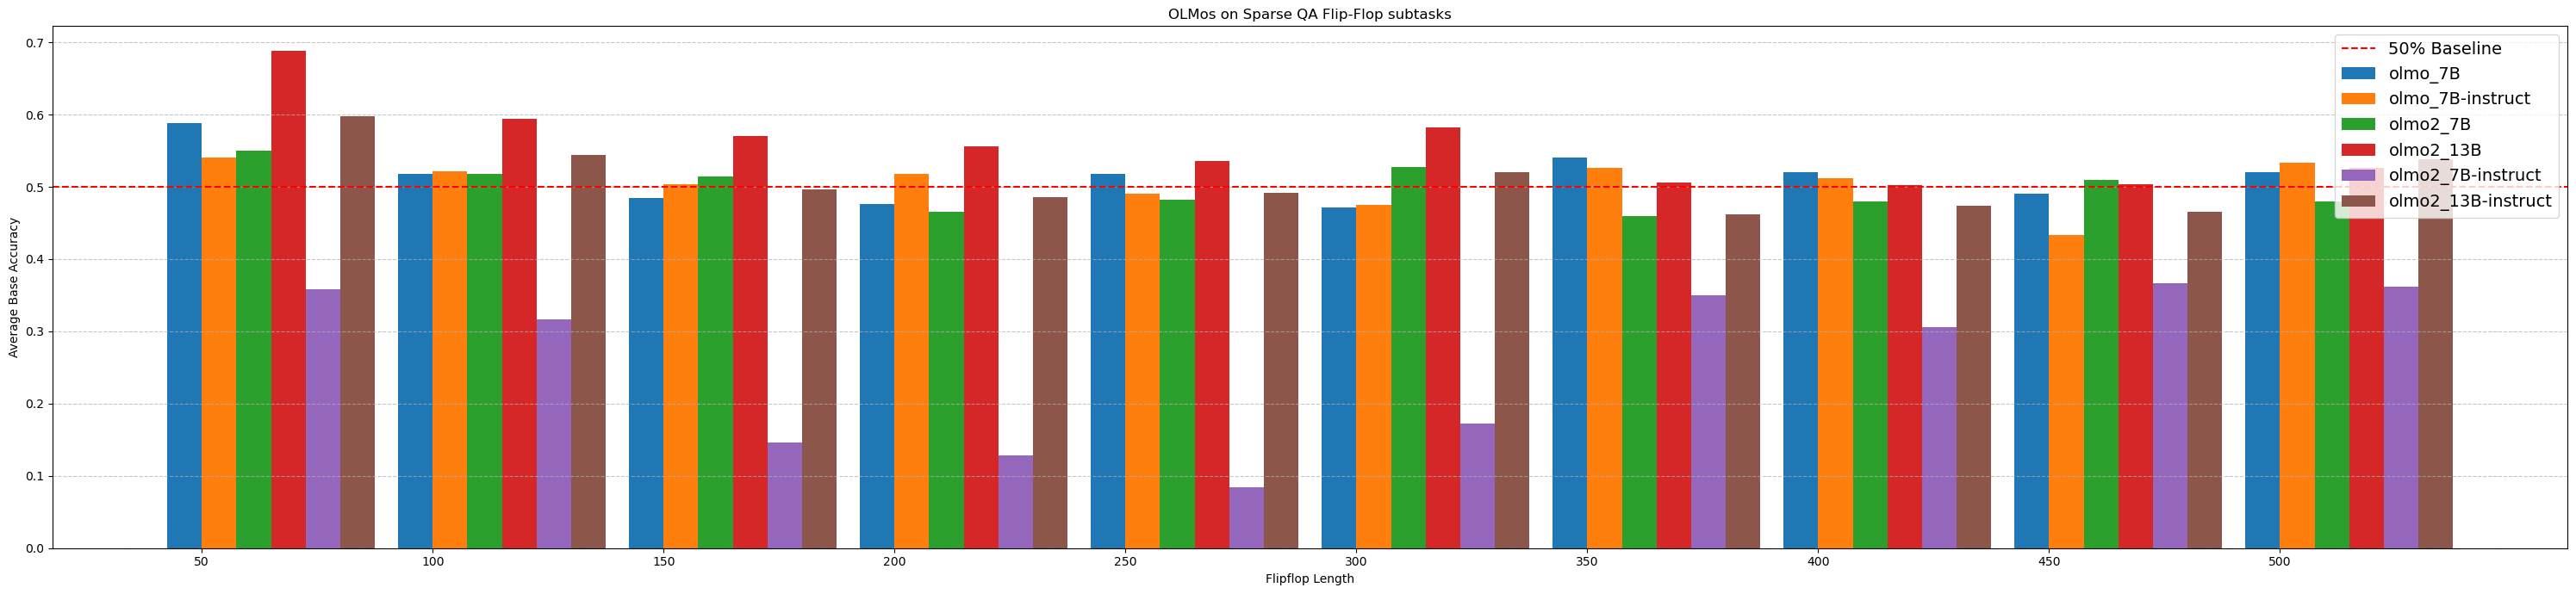

In [21]:
# SPARSE QA
models = {
    "olmo_7B": ["OLMo_7B/sparse-qa/s1", 
                          "OLMo_7B/sparse-qa/s2", 
                          "OLMo_7B/sparse-qa/s3", 
                          "OLMo_7B/sparse-qa/s4", 
                          "OLMo_7B/sparse-qa/s5"],
    "olmo_7B-instruct": ["OLMo_7B-instruct/sparse-qa/s1", 
                 "OLMo_7B-instruct/sparse-qa/s2", 
                 "OLMo_7B-instruct/sparse-qa/s3", 
                 "OLMo_7B-instruct/sparse-qa/s4", 
                 "OLMo_7B-instruct/sparse/s5"],
        "olmo2_7B": ["OLMo2_7B/sparse/s1", 
            "OLMo2_7B/sparse/s2",
            "OLMo2_7B/sparse/s3",
            "OLMo2_7B/sparse/s4",
            "OLMo2_7B/sparse/s5"],
    "olmo2_13B": ["OLMo2_13B/sparse/s1", 
            "OLMo2_13B/sparse/s2",
            "OLMo2_13B/sparse/s3",
            "OLMo2_13B/sparse/s4",
            "OLMo2_13B/sparse/s5"],
    "olmo2_7B-instruct": ["OLMo2_7B-instruct/sparse/s1", 
            "OLMo2_7B-instruct/sparse/s2",
            "OLMo2_7B-instruct/sparse/s3",
            "OLMo2_7B-instruct/sparse/s4",
            "OLMo2_7B-instruct/sparse/s5"],
    "olmo2_13B-instruct": ["OLMo2_13B-instruct/sparse/s1", 
            "OLMo2_13B-instruct/sparse/s2",
            "OLMo2_13B-instruct/sparse/s3",
            "OLMo2_13B-instruct/sparse/s4",
            "OLMo2_13B-instruct/sparse/s5"]
}
title = "OLMos on Sparse QA Flip-Flop subtasks"
output_path = "graphs/olmos_across_sparse_qa_flipflop.png"
plot_model_accuracy(models, title, output_path, fig_width=30)

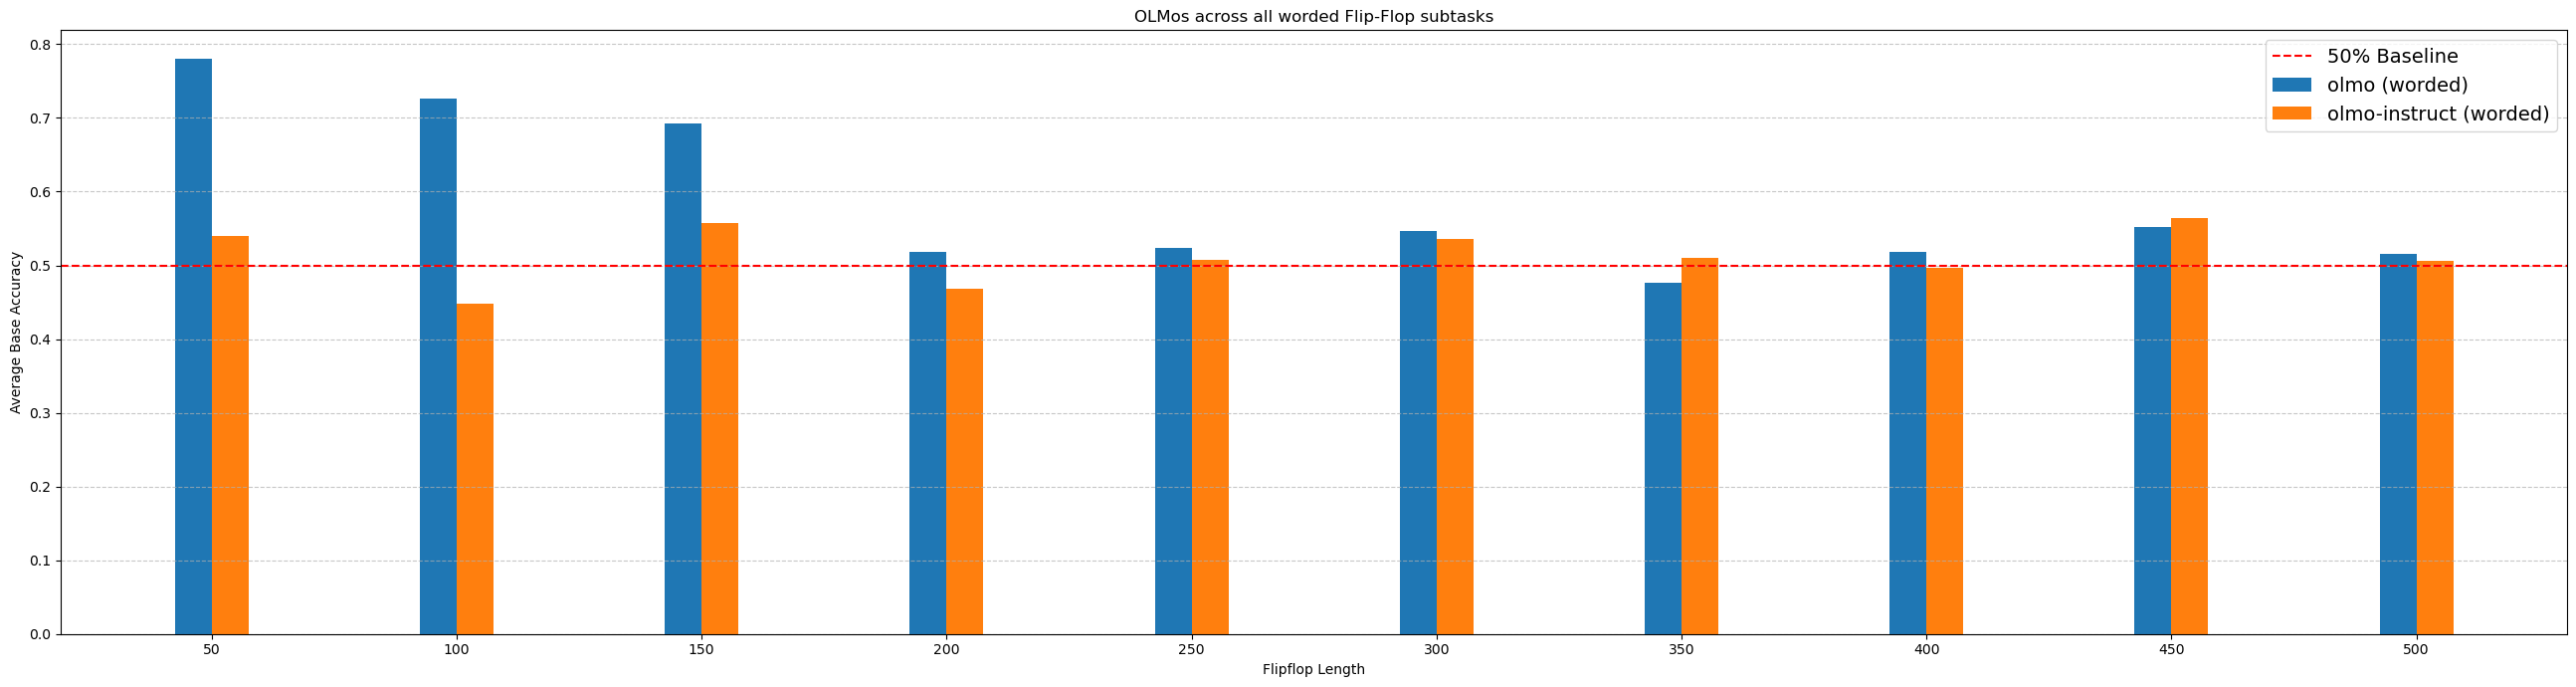

In [99]:
# SPARSE WORDED
models = {
    "olmo (worded)": ["OLMo_7B/sparse-worded/s1", 
                          "OLMo_7B/sparse-worded/s2", 
                          "OLMo_7B/sparse-worded/s3", 
                          "OLMo_7B/sparse-worded/s4", 
                          "OLMo_7B/sparse-worded/s5"],
    "olmo-instruct (worded)": ["OLMo_7B-instruct/sparse-worded/s1", 
                 "OLMo_7B-instruct/sparse-worded/s2", 
                 "OLMo_7B-instruct/sparse-worded/s3", 
                 "OLMo_7B-instruct/sparse-worded/s4", 
                 "OLMo_7B-instruct/sparse-worded/s5"]
}
title = "OLMos across all worded Flip-Flop subtasks"
output_path = "graphs/olmos_across_sparse_worded_flipflop.png"
plot_model_accuracy(models, title, output_path)

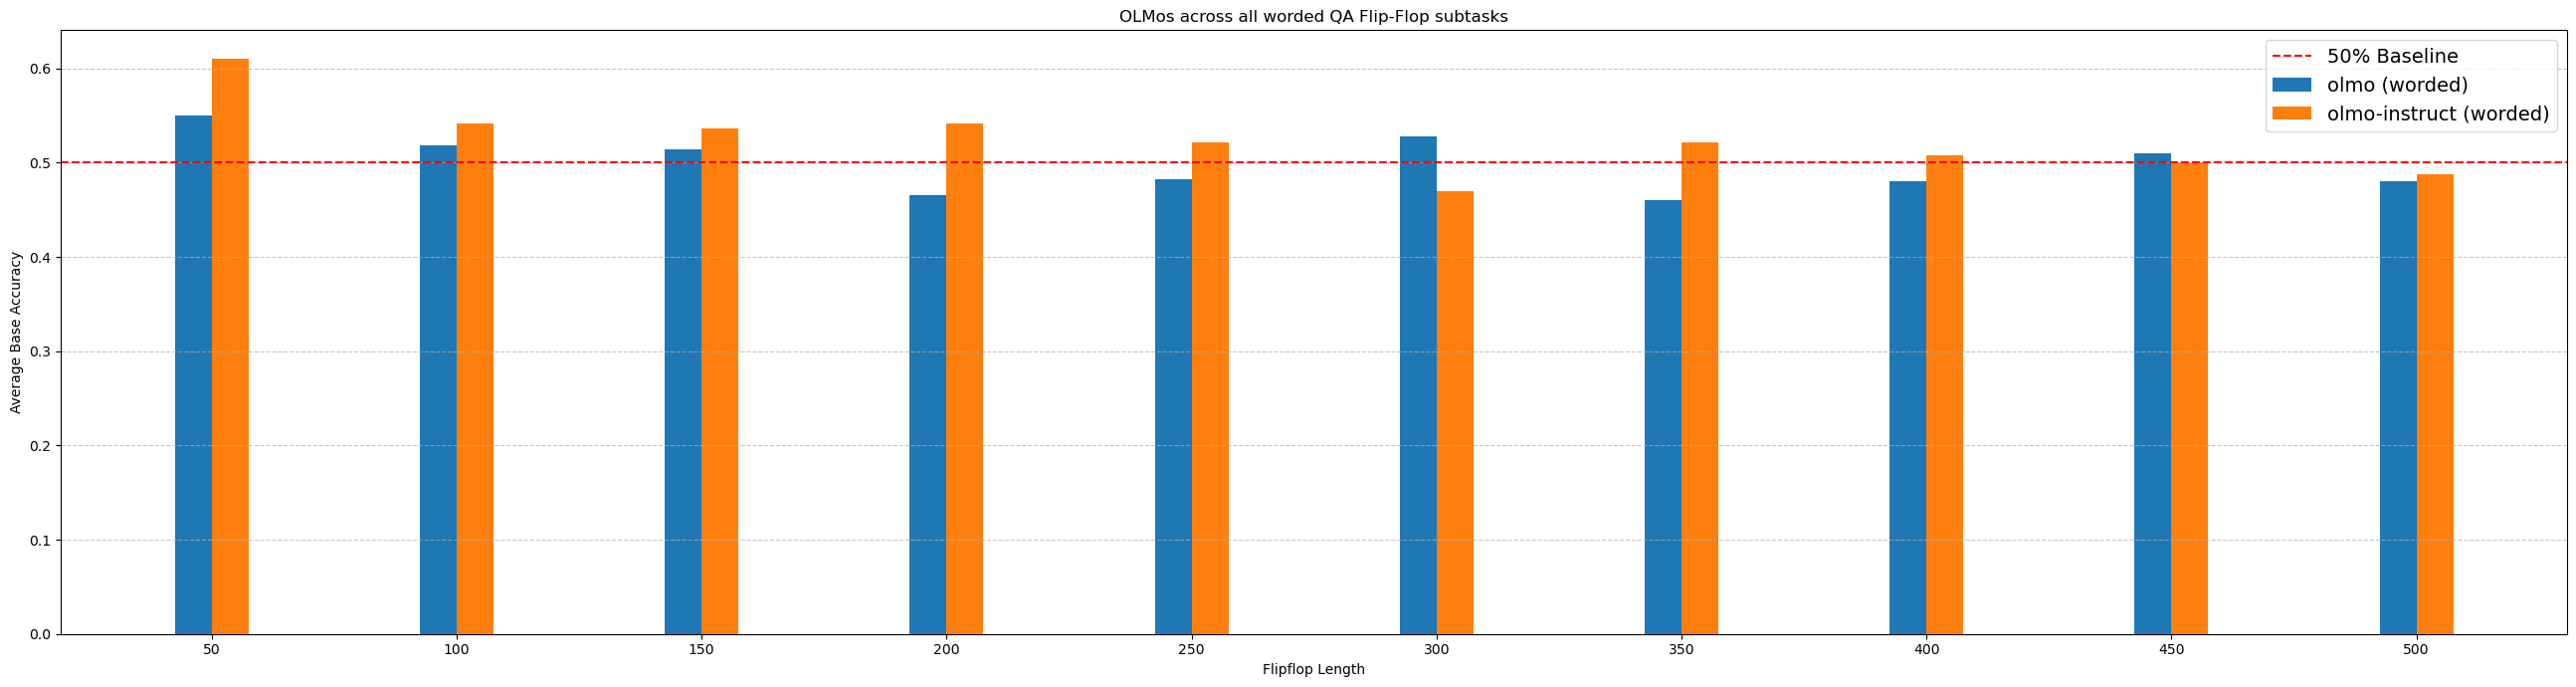

In [100]:
# SPARSE QA WORDED
models = {
    "olmo (worded)": ["OLMo_7B/sparse-qa-worded/s1", 
                          "OLMo_7B/sparse-qa-worded/s2", 
                          "OLMo_7B/sparse-qa-worded/s3", 
                          "OLMo_7B/sparse-qa-worded/s4", 
                          "OLMo_7B/sparse-qa-worded/s5"],
    "olmo-instruct (worded)": ["OLMo_7B-instruct/sparse-qa-worded/s1", 
                 "OLMo_7B-instruct/sparse-qa-worded/s2", 
                 "OLMo_7B-instruct/sparse-qa-worded/s3", 
                 "OLMo_7B-instruct/sparse-qa-worded/s4", 
                 "OLMo_7B-instruct/sparse-qa-worded/s5"]
}
title = "OLMos across all worded QA Flip-Flop subtasks"
output_path = "graphs/olmos_across_sparse_worded_qa_flipflop.png"
plot_model_accuracy(models, title, output_path)

llama3.1_70B: Loaded 295 entries from all folders.
llama3.1_70B-instruct: Loaded 590 entries from all folders.
llama3.3_70B-instruct: Loaded 295 entries from all folders.
llama3.1_8B: Loaded 295 entries from all folders.
llama3.1_8B-instruct: Loaded 295 entries from all folders.


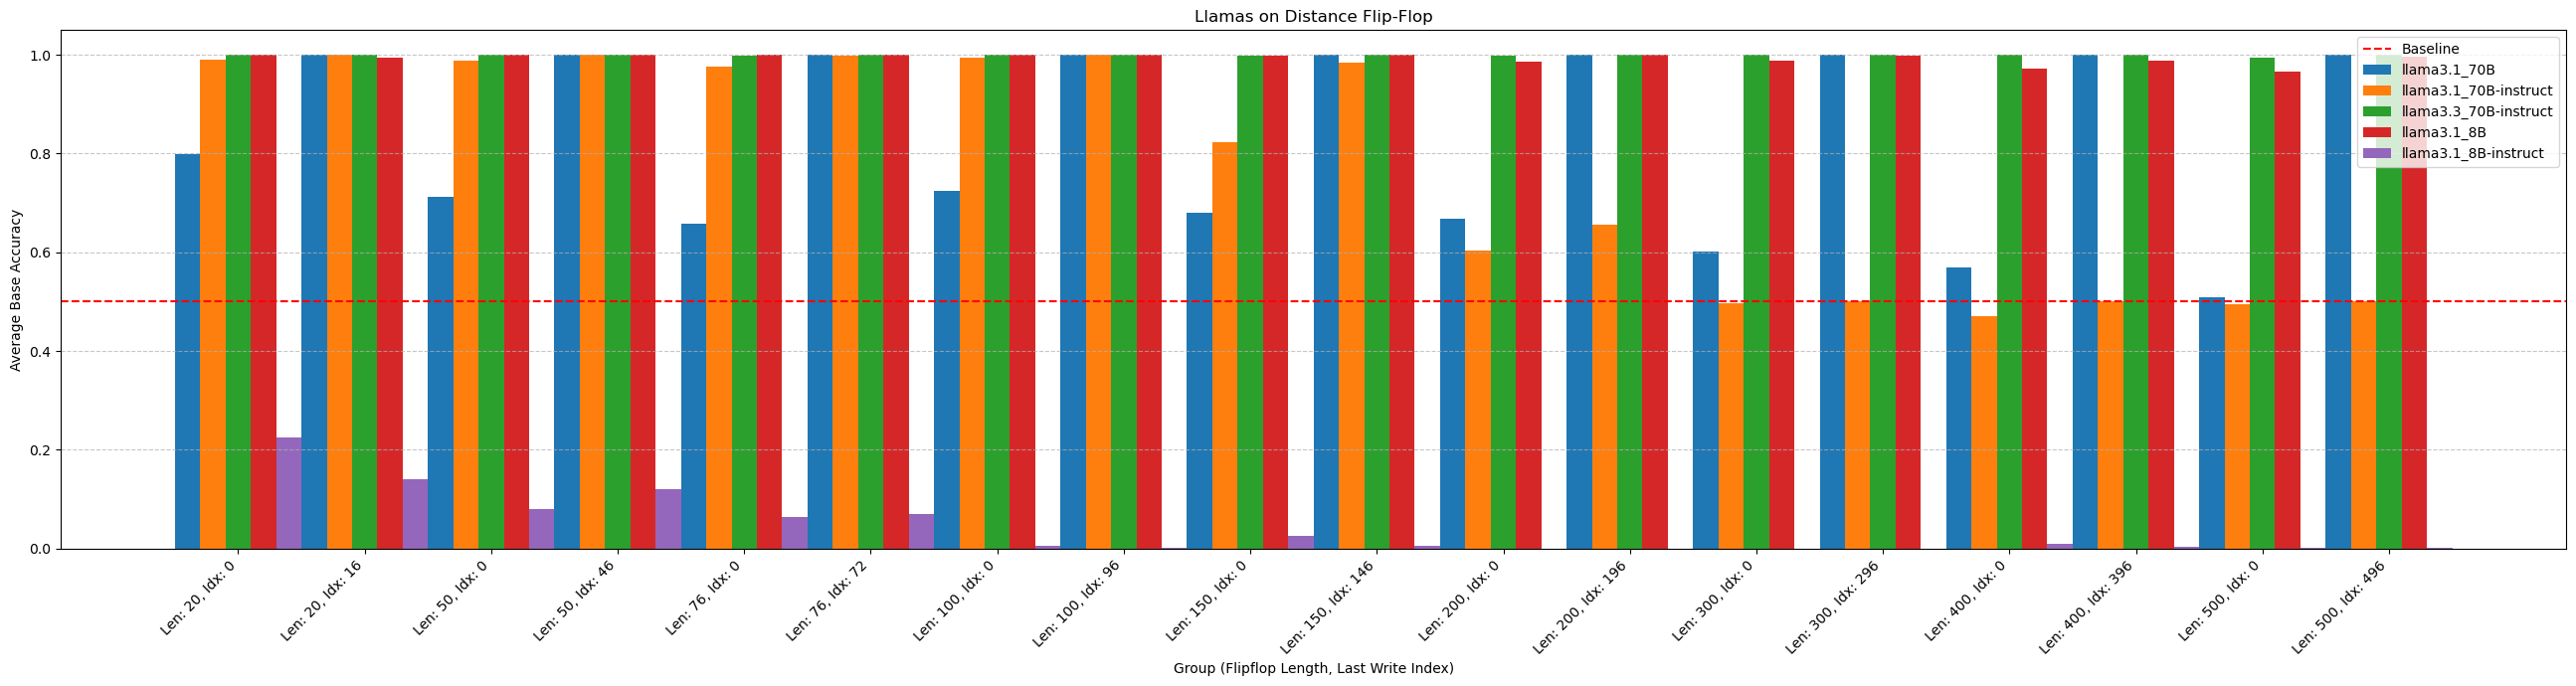

In [16]:
# DISTANCE 
models = {
    "llama3.1_70B": ["llama3.1_70B/distance/s1", 
                          "llama3.1_70B/distance/s2", 
                          "llama3.1_70B/distance/s3", 
                          "llama3.1_70B/distance/s4", 
                          "llama3.1_70B/distance/s5"],
    "llama3.1_70B-instruct": ["llama3.1_70B-instruct/distance/s1", 
                 "llama3.1_70B-instruct/distance/s2", 
                 "llama3.1_70B-instruct/distance/s3", 
                 "llama3.1_70B-instruct/distance/s4", 
                 "llama3.1_70B-instruct/distance/s5"],
    "llama3.3_70B-instruct": ["llama3.3_70B-instruct/distance/s1", 
                 "llama3.3_70B-instruct/distance/s2", 
                 "llama3.3_70B-instruct/distance/s3", 
                 "llama3.3_70B-instruct/distance/s4", 
                 "llama3.3_70B-instruct/distance/s5"],
        "llama3.1_8B": ["llama3.1_8B/distance/s1", 
                 "llama3.1_8B/distance/s2", 
                 "llama3.1_8B/distance/s3", 
                 "llama3.1_8B/distance/s4", 
                 "llama3.1_8B/distance/s5"],
    "llama3.1_8B-instruct": ["llama3.1_8B-instruct/distance/s1", 
                          "llama3.1_8B-instruct/distance/s2", 
                          "llama3.1_8B-instruct/distance/s3", 
                          "llama3.1_8B-instruct/distance/s4", 
                          "llama3.1_8B-instruct/distance/s5"]
}
title = "Llamas on Distance Flip-Flop"
output_path = "graphs/llamas_across_distance_flipflop.png"
plot_distance_accuracy(models, title, output_path)

llama3.1_70B: Loaded 353 entries from all folders.
llama3.1_70B-instruct: Loaded 294 entries from all folders.
llama3.3_70B-instruct: Loaded 295 entries from all folders.
llama3.1_8B: Loaded 295 entries from all folders.
llama3.1_8B-instruct: Loaded 295 entries from all folders.


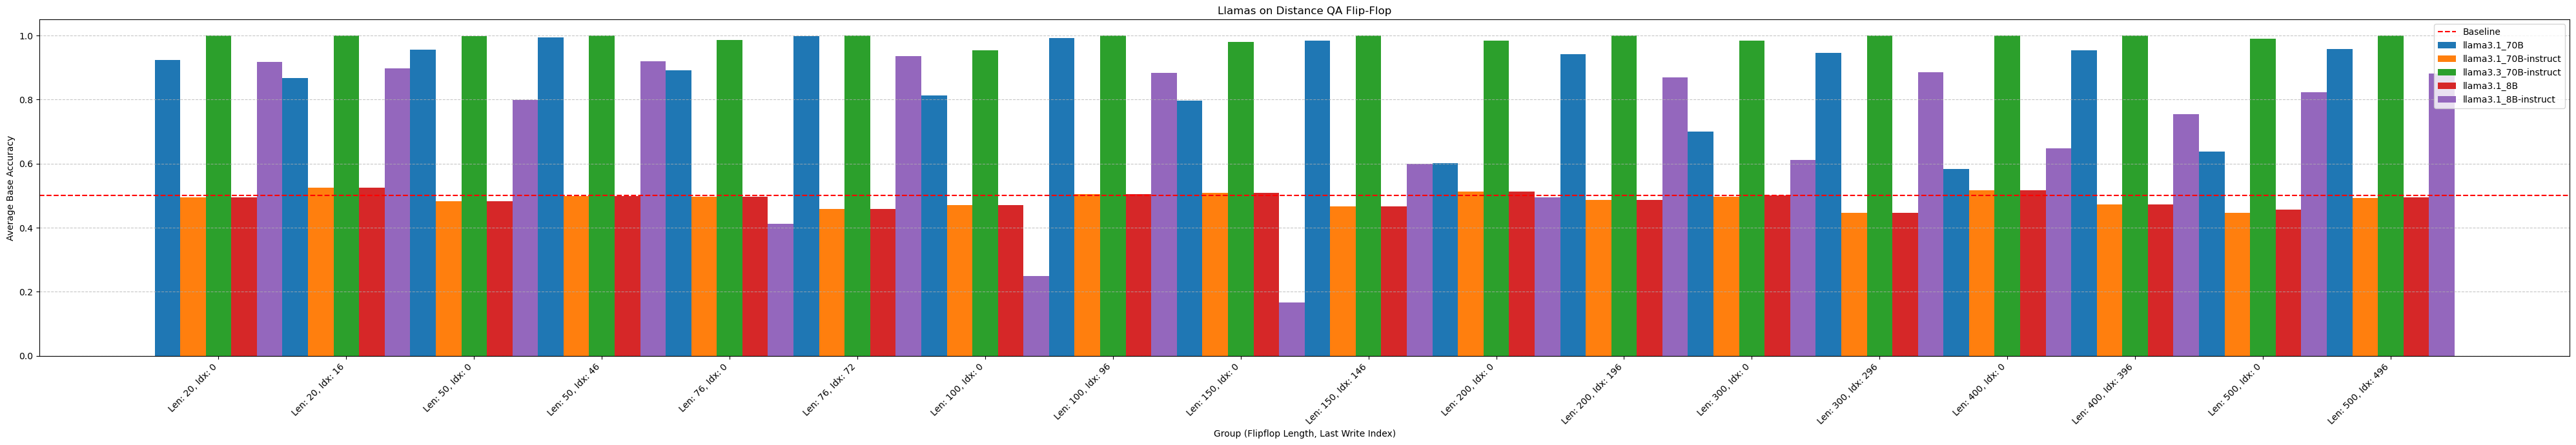

In [44]:
# DISTANCE 
models = {
    "llama3.1_70B": ["llama3.1_70B/distance-qa/s1", 
                          "llama3.1_70B/distance-qa/s2", 
                          "llama3.1_70B/distance-qa/s2", 
                          "llama3.1_70B/distance-qa/s3", 
                          "llama3.1_70B/distance-qa/s4", 
                          "llama3.1_70B/distance-qa/s5"],
    "llama3.1_70B-instruct": ["llama3.1_70B-instruct/distance-qa/s1", 
                 "llama3.1_70B-instruct/distance-qa/s2", 
                 "llama3.1_70B-instruct/distance-qa/s3", 
                 "llama3.1_70B-instruct/distance-qa/s4", 
                 "llama3.1_70B-instruct/distance-qa/s5"],
    "llama3.3_70B-instruct": ["llama3.3_70B-instruct/distance-qa/s1", 
                 "llama3.3_70B-instruct/distance-qa/s2", 
                 "llama3.3_70B-instruct/distance-qa/s3", 
                 "llama3.3_70B-instruct/distance-qa/s4", 
                 "llama3.3_70B-instruct/distance-qa/s5"],
        "llama3.1_8B": ["llama3.1_8B/distance-qa/s1", 
                 "llama3.1_8B/distance-qa/s2", 
                 "llama3.1_8B/distance-qa/s3", 
                 "llama3.1_8B/distance-qa/s4", 
                 "llama3.1_8B/distance-qa/s5"],
    "llama3.1_8B-instruct": ["llama3.1_8B-instruct/distance-qa/s1", 
                          "llama3.1_8B-instruct/distance-qa/s2", 
                          "llama3.1_8B-instruct/distance-qa/s3", 
                          "llama3.1_8B-instruct/distance-qa/s4", 
                          "llama3.1_8B-instruct/distance-qa/s5"]
}
title = "Llamas on Distance QA Flip-Flop"
output_path = "graphs/llamas_across_distance_qa_flipflop.png"
plot_distance_accuracy(models, title, output_path, fig_width=40,)

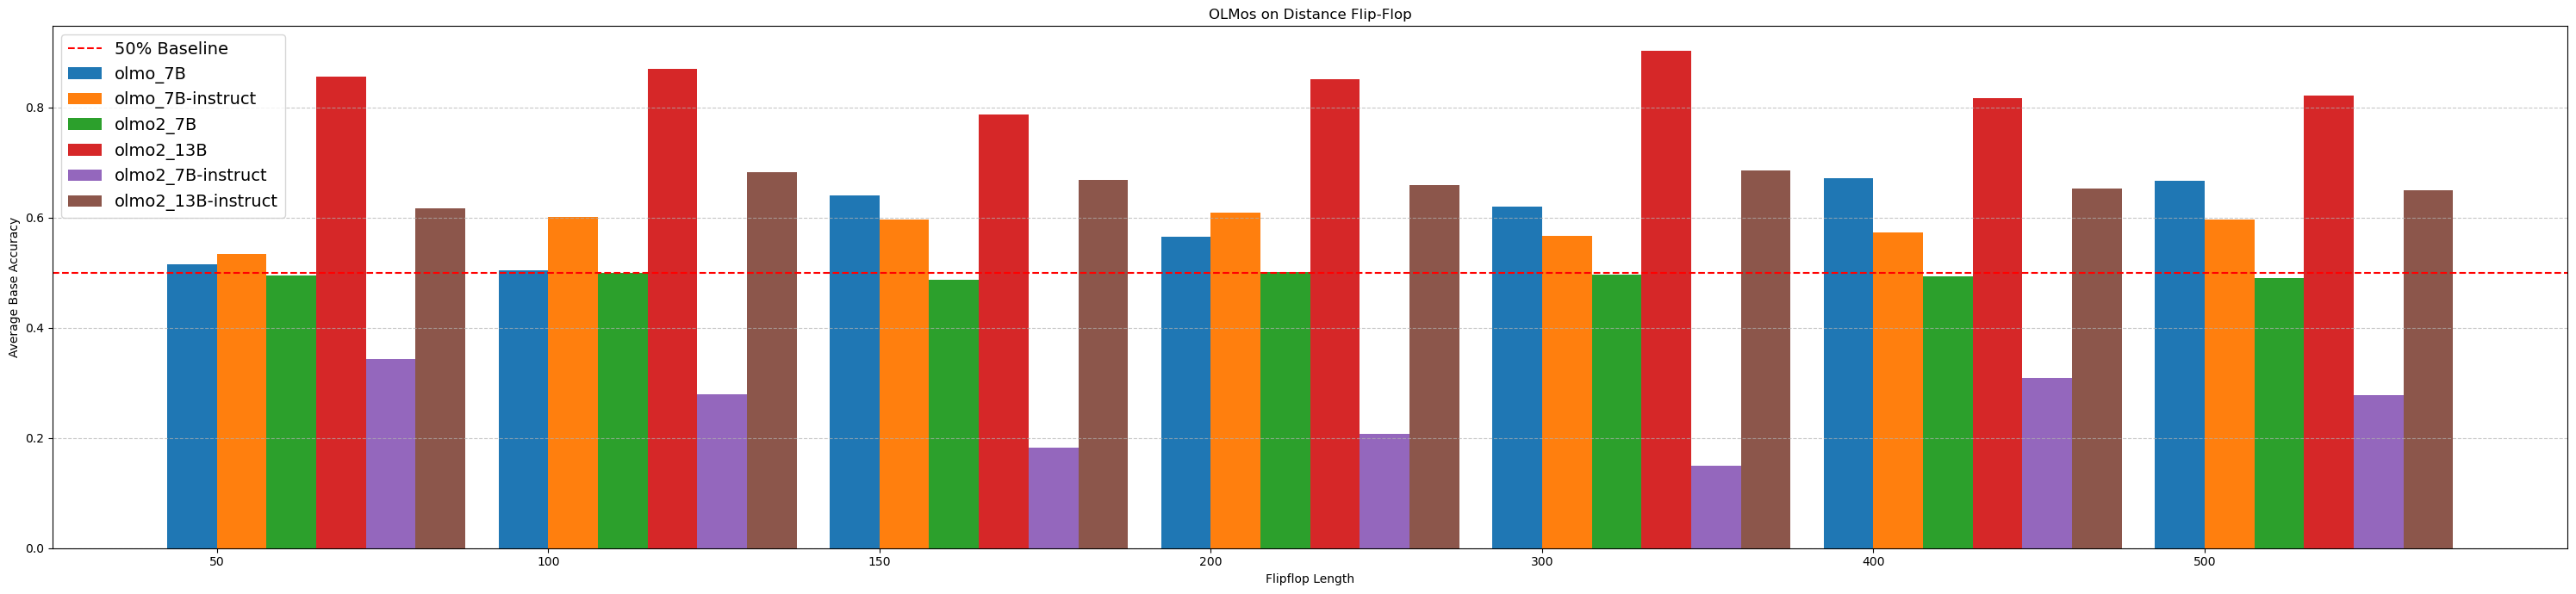

In [22]:
# DISTANCE
models = {
    "olmo_7B": ["OLMo_7B/distance/s1", 
                          "OLMo_7B/distance/s2", 
                          "OLMo_7B/distance/s3", 
                          "OLMo_7B/distance/s4", 
                          "OLMo_7B/distance/s5"],
    "olmo_7B-instruct": ["OLMo_7B-instruct/distance/s1", 
                 "OLMo_7B-instruct/distance/s2", 
                 "OLMo_7B-instruct/distance/s3", 
                 "OLMo_7B-instruct/distance/s4", 
                 "OLMo_7B-instruct/distance/s5"],
        "olmo2_7B": ["OLMo2_7B/distance/s1", 
            "OLMo2_7B/distance/s2",
            "OLMo2_7B/distance/s3",
            "OLMo2_7B/distance/s4",
            "OLMo2_7B/distance/s5"],
    "olmo2_13B": ["OLMo2_13B/distance/s1", 
            "OLMo2_13B/distance/s2",
            "OLMo2_13B/distance/s3",
            "OLMo2_13B/distance/s4",
            "OLMo2_13B/distance/s5"],
    "olmo2_7B-instruct": ["OLMo2_7B-instruct/distance/s1", 
            "OLMo2_7B-instruct/distance/s2",
            "OLMo2_7B-instruct/distance/s3",
            "OLMo2_7B-instruct/distance/s4",
            "OLMo2_7B-instruct/distance/s5"],
    "olmo2_13B-instruct": ["OLMo2_13B-instruct/distance/s1", 
            "OLMo2_13B-instruct/distance/s2",
            "OLMo2_13B-instruct/distance/s3",
            "OLMo2_13B-instruct/distance/s4",
            "OLMo2_13B-instruct/distance/s5"]
}
title = "OLMos on Distance Flip-Flop"
output_path = "graphs/olmos_across_distance_flipflop.png"
plot_model_accuracy(models, title, output_path, fig_width=30)

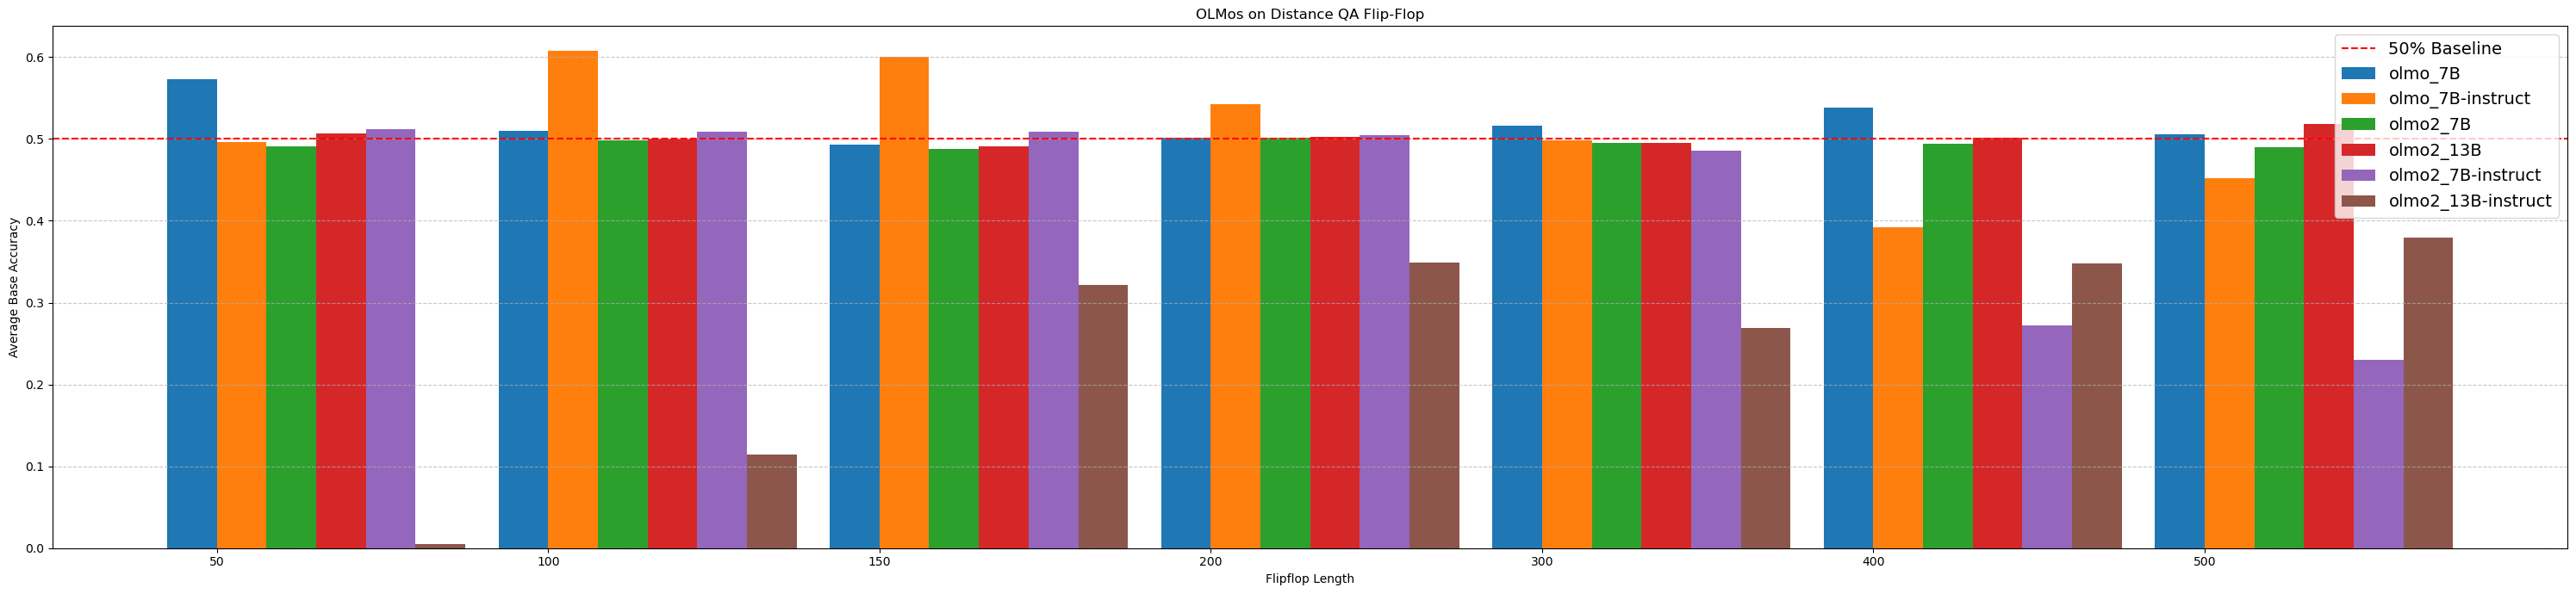

In [23]:
# DISTANCE
models = {
    "olmo_7B": ["OLMo_7B/distance-qa/s1", 
                          "OLMo_7B/distance-qa/s2", 
                          "OLMo_7B/distance-qa/s3", 
                          "OLMo_7B/distance-qa/s4", 
                          "OLMo_7B/distance-qa/s5"],
    "olmo_7B-instruct": ["OLMo_7B-instruct/distance-qa/s1", 
                 "OLMo_7B-instruct/distance-qa/s2", 
                 "OLMo_7B-instruct/distance-qa/s3", 
                 "OLMo_7B-instruct/distance-qa/s4", 
                 "OLMo_7B-instruct/distance-qa/s5"],
        "olmo2_7B": ["OLMo2_7B/distance-qa/s1", 
            "OLMo2_7B/distance-qa/s2",
            "OLMo2_7B/distance-qa/s3",
            "OLMo2_7B/distance-qa/s4",
            "OLMo2_7B/distance-qa/s5"],
    "olmo2_13B": ["OLMo2_13B/distance-qa/s1", 
            "OLMo2_13B/distance-qa/s2",
            "OLMo2_13B/distance-qa/s3",
            "OLMo2_13B/distance-qa/s4",
            "OLMo2_13B/distance-qa/s5"],
    "olmo2_7B-instruct": ["OLMo2_7B-instruct/distance-qa/s1", 
            "OLMo2_7B-instruct/distance-qa/s2",
            "OLMo2_7B-instruct/distance-qa/s3",
            "OLMo2_7B-instruct/distance-qa/s4",
            "OLMo2_7B-instruct/distance-qa/s5"],
    "olmo2_13B-instruct": ["OLMo2_13B-instruct/distance-qa/s1", 
            "OLMo2_13B-instruct/distance-qa/s2",
            "OLMo2_13B-instruct/distance-qa/s3",
            "OLMo2_13B-instruct/distance-qa/s4",
            "OLMo2_13B-instruct/distance-qa/s5"]
}
title = "OLMos on Distance QA Flip-Flop"
output_path = "graphs/olmos_across_distance_qa_flipflop.png"
plot_model_accuracy(models, title, output_path, fig_width=30)